# Instructions

To run this series of scripts, first download the data cube:

`J0014m0028_dr2_zap_wpsf1_qsosub.corrEBV`

and place it in the **same folder** as this Jupyter notebook.  

The data cube is available here: [MUSE Field Data - J0014m0028](https://amused.univ-lyon1.fr/project/megaflow/fieldsdata/J0014m0028).  

To get the **quasar-subtracted data cube**, click on **"MUSE (psfsub)"**. (the qube has a szise of ~3 GB)


<span style="color:red">Or simply automatically download the data into the same folder as this notebook by using the script below</span>



In [ ]:
import requests
from pathlib import Path
from tqdm.notebook import tqdm

url = "https://amused.univ-lyon1.fr/data/megaflow/download/J0014m0028/J0014m0028_dr2_zap_wpsf1_qsosub.corrEBV.fits"
filename = Path(url).name


response = requests.get(url, stream=True, verify=False)
response.raise_for_status()

total_size = int(response.headers.get('content-length', 0))
chunk_size = 65536  # adjust dowload chunk szise specific for your ram

with open(filename, "wb") as f, tqdm(total=total_size, unit='B', unit_scale=True, desc=filename) as bar:
    for chunk in response.iter_content(chunk_size=chunk_size):
        f.write(chunk)
        bar.update(len(chunk))

print(f"\nDownloaded '{filename}' to the current folder.")


# Interim Results Folder

Interim results are stored in the **"interim processing data"** subfolder, which is expected to be in the **same folder** as this notebook.  

Simply run the script below to create the folder. If the folder already exists, running the script will make **no changes**.


In [6]:
import os

folder_name = "interim processing data"

if not os.path.exists(folder_name):
    os.makedirs(folder_name)
    print(f'Folder "{folder_name}" has been created.')
else:
    print(f'Folder "{folder_name}" already exists. No changes made.')

Folder "interim processing data" has been created.


# Installing Required Packages

This notebook requires several Python packages to run properly. The required packages are:

- `numpy`
- `pandas`
- `scipy`
- `matplotlib`
- `astropy`
- `scikit-learn`
- `scikit-image`
- `emcee`
- `corner`

The script below will automatically check for these packages and install any that are missing.  
If a package is already installed, it will be skipped.


In [7]:

# This script checks if the required packages are installed and installs any that are missing.

import importlib
import subprocess
import sys

# required packages
required_packages = [
    "numpy",
    "pandas",
    "scipy",
    "matplotlib",
    "astropy",
    "scikit-learn",
    "scikit-image",
    "emcee",
    "corner"
]

# Function to install packages via pip
def install_package(package):
    subprocess.check_call([sys.executable, "-m", "pip", "install", package])

# Loop through required packages and install if missing
for package in required_packages:
    try:
        importlib.import_module(package)
        print(f'"{package}" is already installed.')
    except ImportError:
        print(f'"{package}" not found. Installing...')
        install_package(package)
        print(f'"{package}" has been installed.')


"numpy" is already installed.
"pandas" is already installed.
"scipy" is already installed.
"matplotlib" is already installed.
"astropy" is already installed.
"scikit-learn" not found. Installing...
"scikit-learn" has been installed.
"scikit-image" not found. Installing...
"scikit-image" has been installed.
"emcee" is already installed.
"corner" is already installed.


# STEP A Loading Cube and STEP B Summing Layers

Summed image saved to:
C:\Users\Anwender\Desktop\M.A.G.I.C\interim processing data\DATACUBELAYERSSUMMED.fits


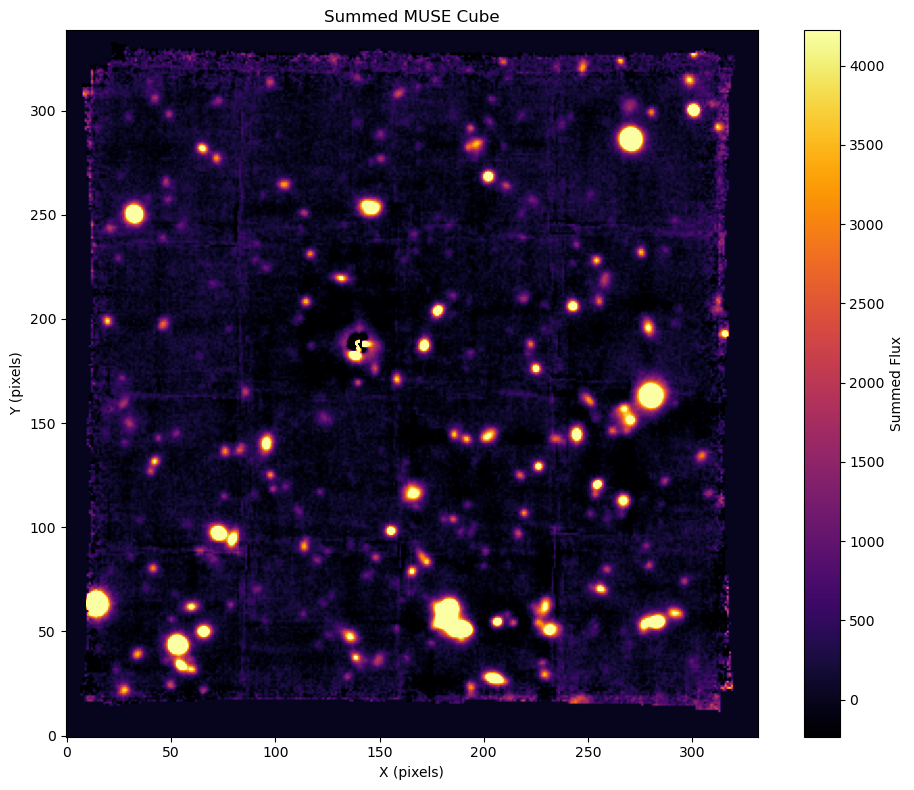

In [1]:
import os
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt

# Input: MUSE data cube FITS file (must be in the same folder as this script).
# Note: Large MUSE mosaics (e.g., HUDF) can be very heavy on memory and CPU.
# In such cases, slicing the cube into smaller regions of interest or 
# summing only every nth spectral layer can significantly reduce computational load.

file_name = "J0014m0028_dr2_zap_wpsf1_qsosub.corrEBV.fits"

# Load the MUSE data cube safely using a context manager
with fits.open(file_name, memmap=True) as hdul:
    data_cube = hdul[1].data.copy()  # copy to memory so we can close the file
    header = hdul[1].header.copy()   # copy header

# Sum all layers of the cube along the spectral axis resulting in a 2D image
summed_image = np.nansum(data_cube, axis=0)

# Create a new header for the 2D image, keeping only spatial WCS info
new_header = header.copy()
new_header['NAXIS'] = 2
for key in ['NAXIS3', 'CTYPE3', 'CRVAL3', 'CRPIX3', 'CDELT3', 'CD3_3', 'LAMBDA']:
    if key in new_header:
        del new_header[key]
new_header['COMMENT'] = f"Summed along spectral axis from {file_name}"

# Define /create output folder relative to the current working directory
script_dir = os.getcwd()
output_dir = os.path.join(script_dir, "interim processing data")
os.makedirs(output_dir, exist_ok=True)  
output_path = os.path.join(output_dir, "DATACUBELAYERSSUMMED.fits")

# Write the summed image to a new FITS file
fits.writeto(output_path, summed_image, header=new_header, overwrite=True)
print(f"Summed image saved to:\n{output_path}")

# Plot the 2D summed image
plt.figure(figsize=(10, 8))
plt.imshow(summed_image, origin='lower', cmap='inferno',
           vmin=np.percentile(summed_image, 5),
           vmax=np.percentile(summed_image, 99))
plt.colorbar(label='Summed Flux')
plt.title("Summed MUSE Cube")
plt.xlabel("X (pixels)")
plt.ylabel("Y (pixels)")
plt.tight_layout()
plt.show()


# STEP C Galaxy detection and Ellipse Fitting

Loaded summed FITS from:
C:\Users\Anwender\Desktop\M.A.G.I.C\interim processing data\DATACUBELAYERSSUMMED.fits
Cluster 0 - Centroid: (55.05, 33.77), Major Axis: 4.38, Minor Axis: 2.70, Angle: 144.16°
Cluster 1 - Centroid: (53.22, 43.77), Major Axis: 6.24, Minor Axis: 5.65, Angle: 148.04°
Cluster 2 - Centroid: (65.67, 50.12), Major Axis: 3.80, Minor Axis: 3.08, Angle: 160.40°
Cluster 3 - Centroid: (59.83, 61.83), Major Axis: 2.10, Minor Axis: 1.55, Angle: 45.00°


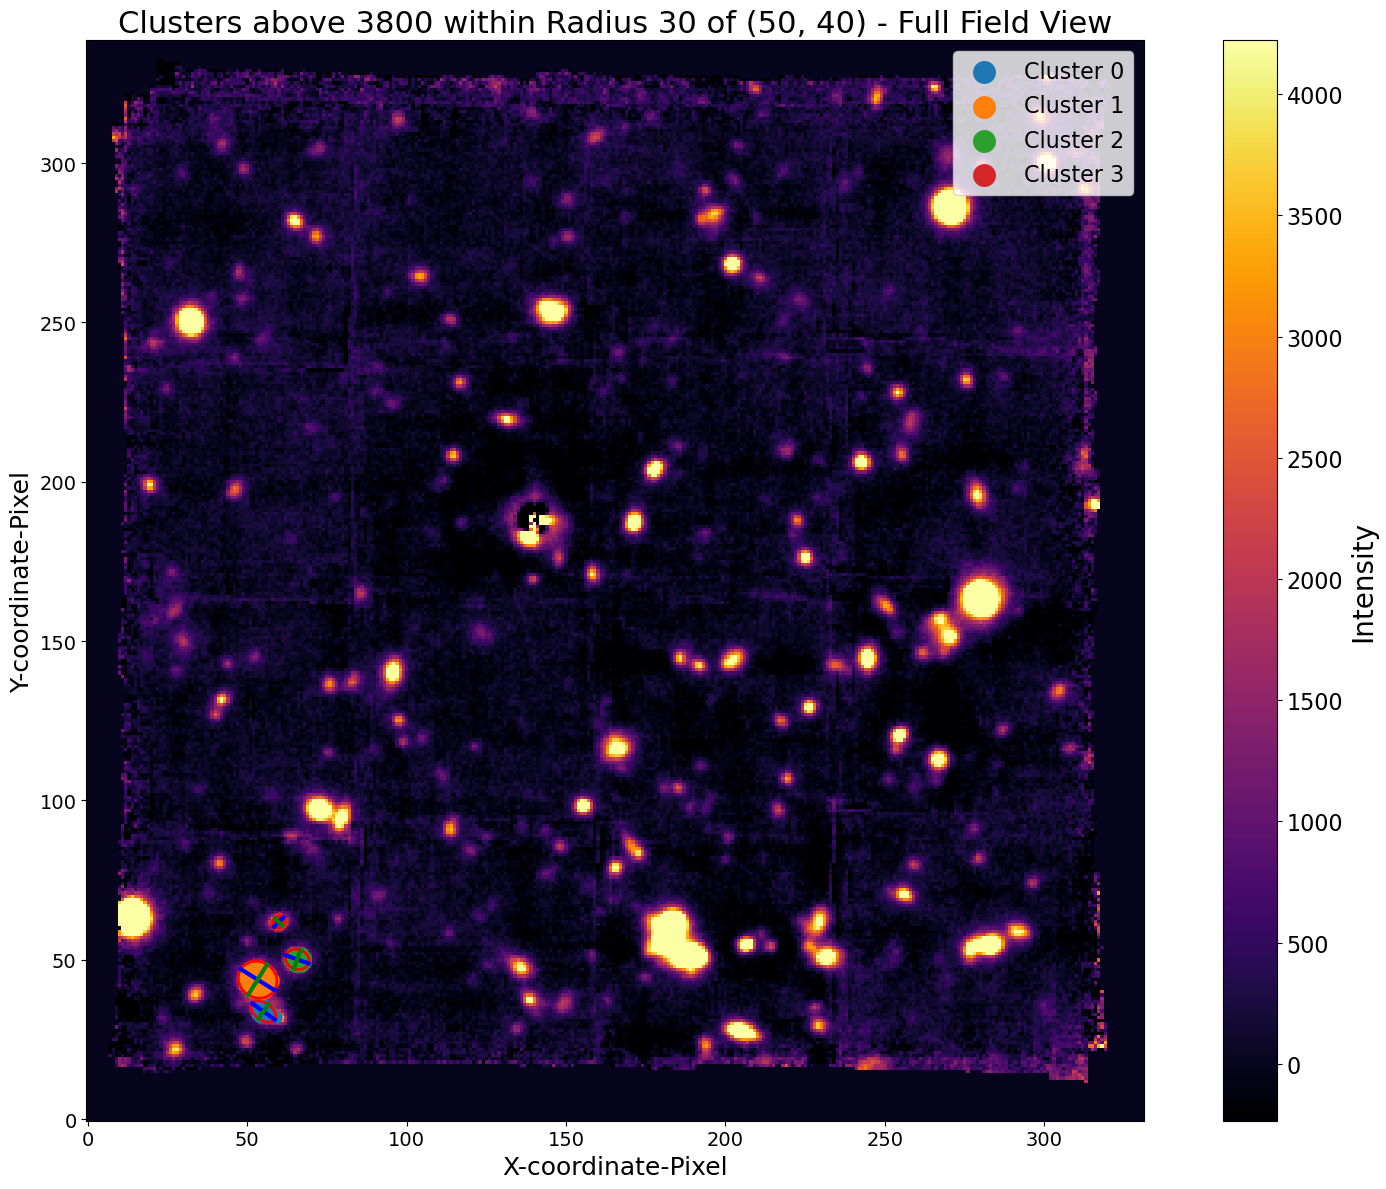

Zoomed view: x=[39.0, 78.0], y=[22.0, 73.0]


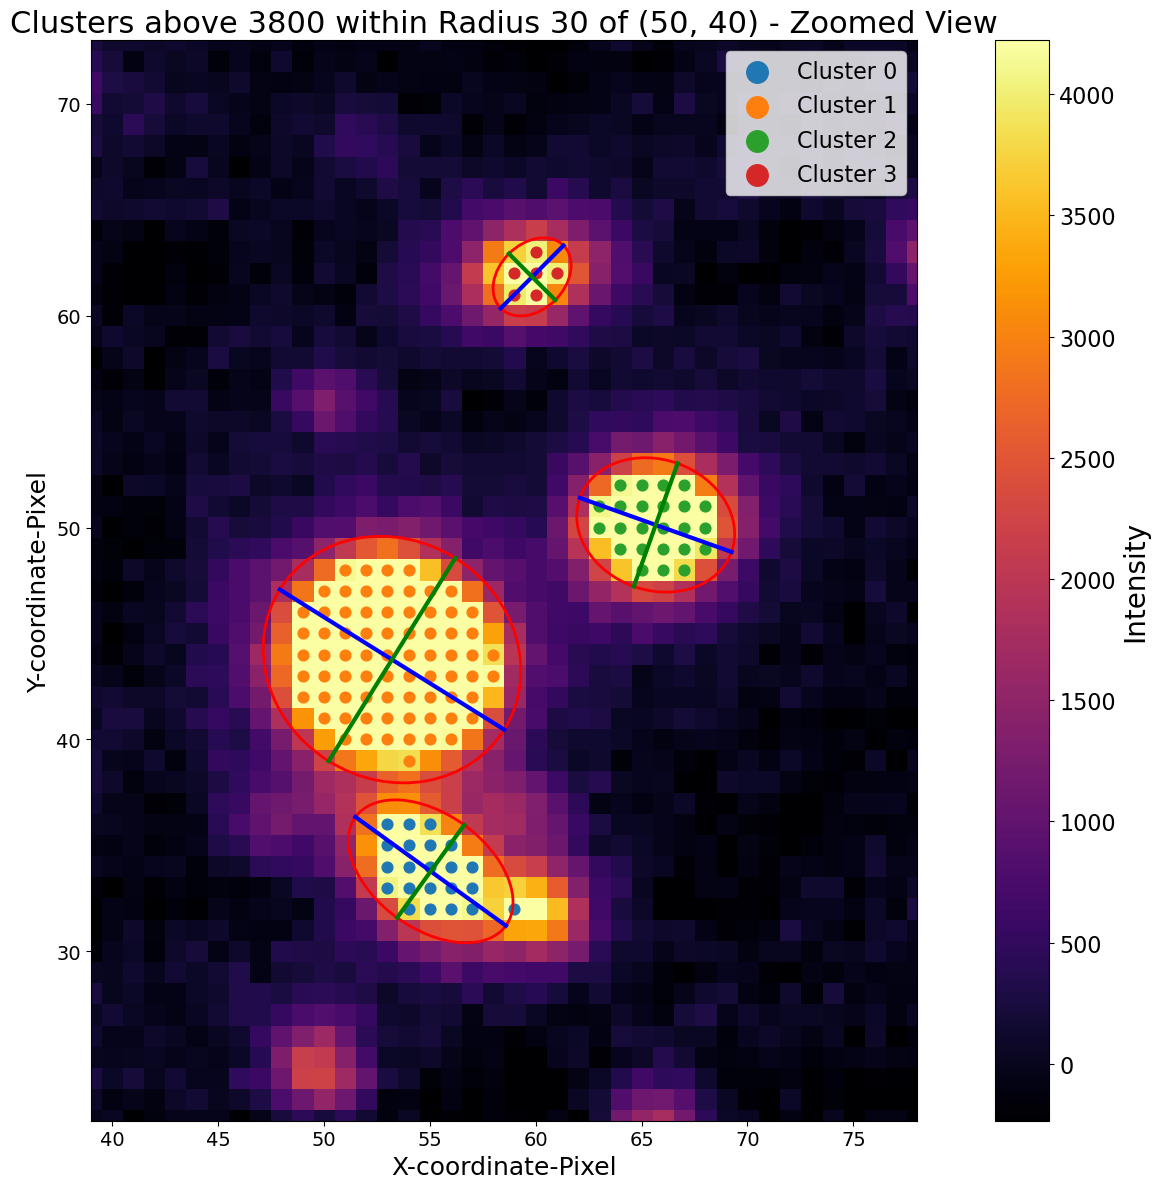

In [2]:
import os
import numpy as np
from astropy.io import fits
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

# =========================================================
# ========== ADJUSTABLE PARAMETERS ========================
# =========================================================

# Region of interest in the FOV (center coordinates and radius) optional but a must have for large data qubes
center_x = 50       
center_y = 40       
radius   = 30       

# Pixel detection threshold
threshold_value = 3800  # Intensity threshold for pixel detection, 
                        #lower values results in dimmer pixels being detected can result in merging of grouped pixel clusters

# DBSCAN clustering parameters
eps        = 2   # Neighborhood radius
min_samples = 6  # Minimum pixels to form a cluster

# Plotting parameters
colormap   = "inferno"  
percentile_vmin = 5     
percentile_vmax = 99   
point_size = 60      

# Zoom parameters
zoom_margin = 10  # Additional zoomed in view

# ============================================================ 

fits_filename = "DATACUBELAYERSSUMMED.fits"   
fits_subdir   = "interim processing data"

script_dir = os.getcwd()
output_dir = os.path.join(script_dir, fits_subdir)
fits_file = os.path.join(output_dir, fits_filename)

with fits.open(fits_file) as hdul:
    data = hdul[0].data.copy()  
print(f"Loaded summed FITS from:\n{fits_file}")

# Threshold selection
above_threshold_pixels = np.where(data > threshold_value)
pixel_coordinates = np.column_stack((above_threshold_pixels[0], above_threshold_pixels[1]))
distances = np.sqrt((pixel_coordinates[:, 1] - center_x)**2 + (pixel_coordinates[:, 0] - center_y)**2) 
filtered_pixel_coordinates = pixel_coordinates[distances <= radius]

# DBSCAN clustering
dbscan = DBSCAN(eps=eps, min_samples=min_samples)
clusters = dbscan.fit_predict(filtered_pixel_coordinates)

unique_clusters = [c for c in np.unique(clusters) if c != -1]
ellipses = []
all_cluster_points = []

for cluster in unique_clusters:
    cluster_pixels = filtered_pixel_coordinates[clusters == cluster]
    if cluster_pixels.size == 0:
        continue

    x, y = cluster_pixels[:, 1], cluster_pixels[:, 0]
    cov = np.cov(x, y)
    eigvals, eigvecs = np.linalg.eigh(cov)
    order = eigvals.argsort()[::-1]
    eigvals, eigvecs = eigvals[order], eigvecs[:, order]

    major_vec, minor_vec = eigvecs[:, 0], eigvecs[:, 1]
    angle = np.degrees(np.arctan2(major_vec[1], major_vec[0]))

    scale = np.sqrt(5.991 * eigvals)  # 95% confidence ellipse
    major_radius, minor_radius = scale
    centroid_x, centroid_y = x.mean(), y.mean()

    print(f'Cluster {cluster} - Centroid: ({centroid_x:.2f}, {centroid_y:.2f}), '
          f'Major Axis: {major_radius:.2f}, Minor Axis: {minor_radius:.2f}, '
          f'Angle: {angle:.2f}°')

    ellipses.append((centroid_x, centroid_y, 2*major_radius, 2*minor_radius, angle, major_vec, minor_vec))
    all_cluster_points.append(cluster_pixels)

    
# creating the plot with ellipses
def create_plot(data, xlim=None, ylim=None, title_suffix=""):
    plt.figure(figsize=(16, 12))
    plt.imshow(data, origin='lower', cmap=colormap,
               vmin=np.percentile(data, percentile_vmin),
               vmax=np.percentile(data, percentile_vmax))
    
    if xlim is not None and ylim is not None:
        plt.xlim(xlim)
        plt.ylim(ylim)

    cbar = plt.colorbar()
    cbar.set_label('Intensity', fontsize=20)
    cbar.ax.tick_params(labelsize=16)

    title = f'Clusters above {threshold_value} within Radius {radius} of ({center_x}, {center_y}){title_suffix}'
    plt.title(title, fontsize=22)
    plt.xlabel('X-coordinate-Pixel', fontsize=18)
    plt.ylabel('Y-coordinate-Pixel', fontsize=18)

    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)

    # Plot cluster points and ellipses
    ax = plt.gca()
    for i, cluster in enumerate(unique_clusters):
        cluster_pixels = filtered_pixel_coordinates[clusters == cluster]
        if cluster_pixels.size == 0:
            continue
        x, y = cluster_pixels[:, 1], cluster_pixels[:, 0]  # CORRECTED LINE
        plt.scatter(x, y, s=point_size, label=f'Cluster {cluster}')

    # Overplotting ellipses
    for cx, cy, w, h, angle, major_vec, minor_vec in ellipses:
        ax.add_patch(Ellipse((cx, cy), w, h, angle=angle, edgecolor='red', fc='None', lw=2))
        ax.plot([cx - 0.5*w*major_vec[0], cx + 0.5*w*major_vec[0]],
                [cy - 0.5*w*major_vec[1], cy + 0.5*w*major_vec[1]],
                color='blue', linestyle='-', linewidth=3)
        ax.plot([cx - 0.5*h*minor_vec[0], cx + 0.5*h*minor_vec[0]],
                [cy - 0.5*h*minor_vec[1], cy + 0.5*h*minor_vec[1]],
                color='green', linestyle='-', linewidth=3)

    plt.legend(fontsize=16, markerscale=2)
    plt.tight_layout()
    return ax

# Plot 1: Full field view
create_plot(data, title_suffix=" - Full Field View")
plt.show()

# Plot 2: Zoomed-in view around clusters
if len(all_cluster_points) > 0:
    # Calculate zoom region based on all cluster points
    all_points = np.vstack(all_cluster_points)
    x_coords = all_points[:, 1]  # x coordinates (column indices)
    y_coords = all_points[:, 0]  # y coordinates (row indices)
    
    x_min, x_max = x_coords.min() - zoom_margin, x_coords.max() + zoom_margin
    y_min, y_max = y_coords.min() - zoom_margin, y_coords.max() + zoom_margin
    

    print(f"Zoomed view: x=[{x_min:.1f}, {x_max:.1f}], y=[{y_min:.1f}, {y_max:.1f}]")
    
    create_plot(data, xlim=(x_min, x_max), ylim=(y_min, y_max), title_suffix=" - Zoomed View")
    plt.show()
else:
    print("No clusters found for zoomed view")

# STEP D Extract spectra and STEP E Vacuum Correction

CSV file has been saved to: C:\Users\Anwender\Desktop\M.A.G.I.C\interim processing data\summed_spectra.csv
Filename: C:\Users\Anwender\Desktop\M.A.G.I.C\interim processing data\DATACUBELAYERSSUMMED.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  DATA          1 PrimaryHDU      51   (332, 339)   float32   
None


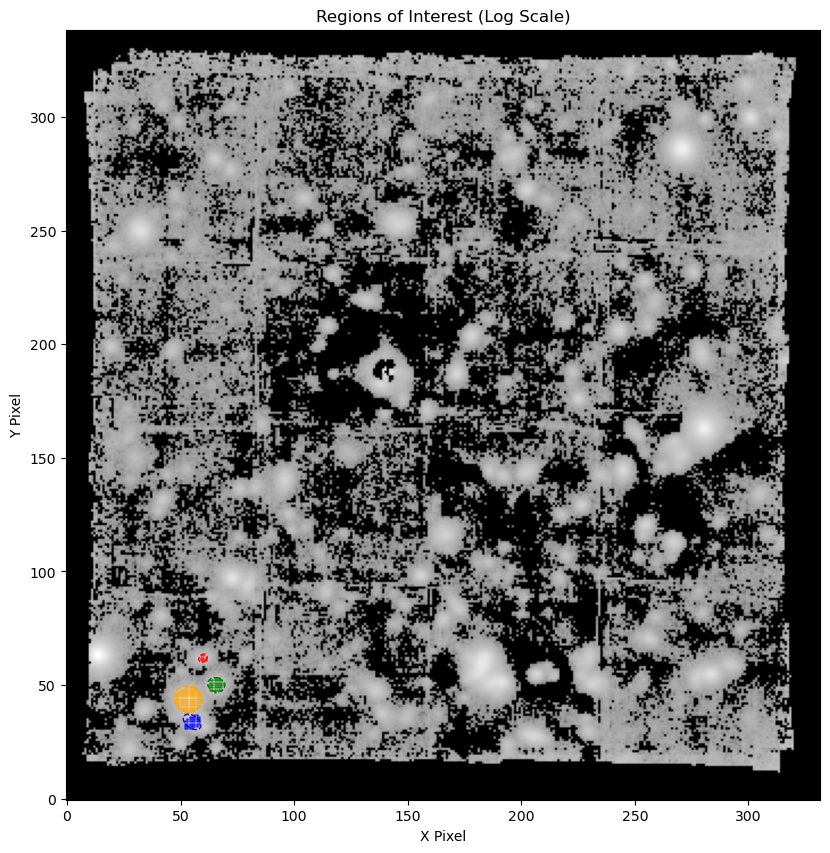

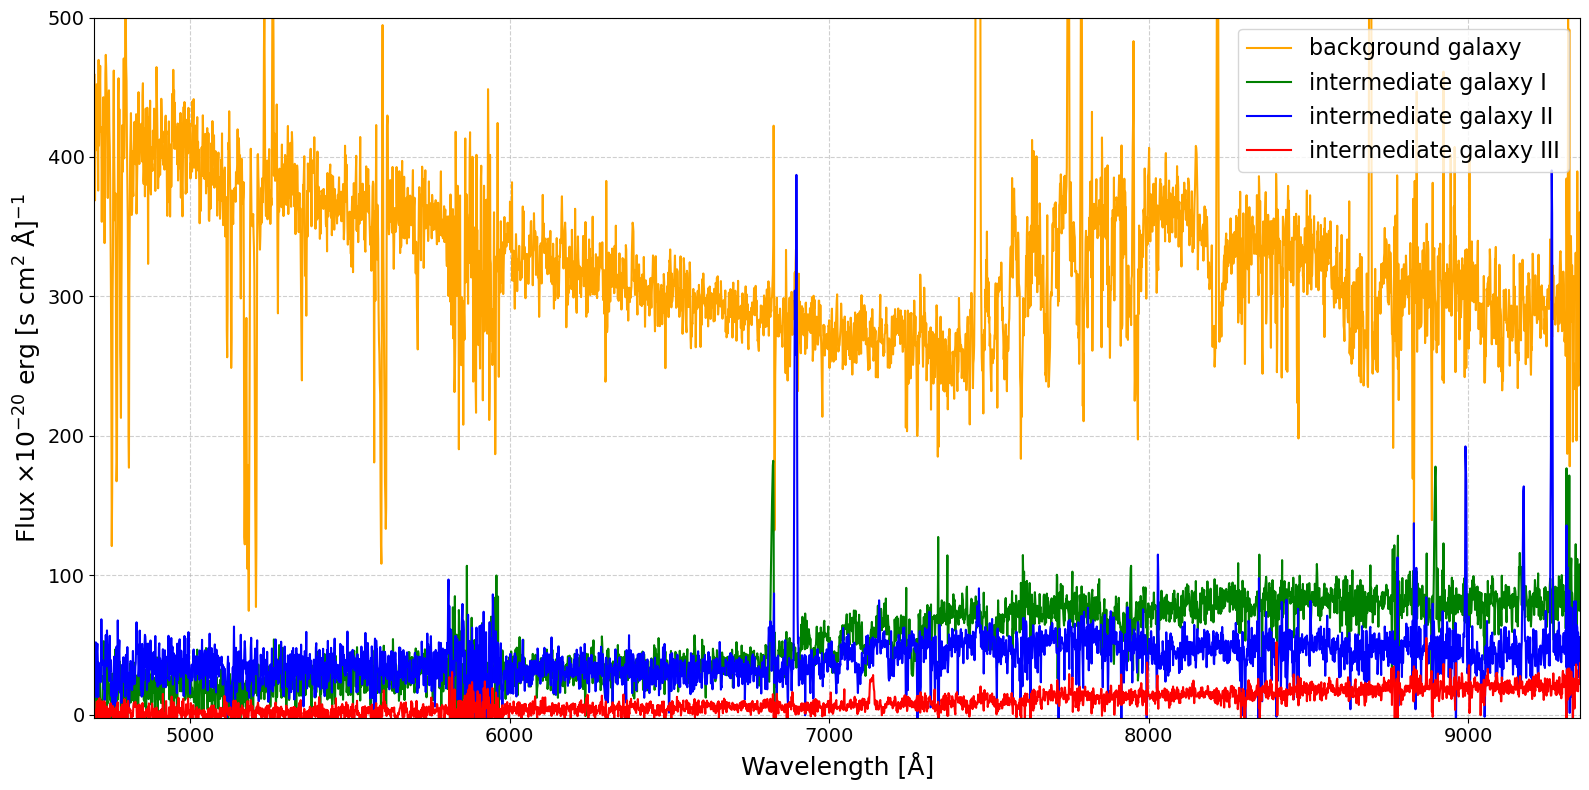

In [1]:
import os
import csv
import numpy as np
import matplotlib.pyplot as plt
from skimage.draw import ellipse
from matplotlib.patches import Ellipse
from astropy.io import fits

# =========================================================
# ========== ADJUSTABLE PARAMETERS ========================
# =========================================================

# --- Ellipse definitions taken from the previous script ---
ELLIPSES = [
    #  x center,     y center,    major axis, minor axis, angle,    label,   color
    (53.22, 43.77,   6.24,       5.65,      148,  "background galaxy",     "orange"),
    (65.67, 50.12,   3.80,       3.08,        160,  "intermediate galaxy I", "g"),
    (55.05, 33.77,   4.38,       2.70,     144,  "intermediate galaxy II","blue"),
    (59.83, 61.83,   2.10,       1.55,        45.00,  "intermediate galaxy III","r")
]

# --- Wavelength setup ---
START_WAVELENGTH_AIR = 4699.62  # Starting wavelength in Å (air),is slightly different for individual data qubes 
                                # ,can be read out from the fits header
DLAMBDA_DEFAULT      = 1.25     # Default spectral resolution dλ (Å) of muse doesnt really change


# --- Observatory conditions (air-to-vacuum conversion) ---
ALTITUDE_M      = 2635       # Paranal altitude [m]
TEMPERATURE_C   = 12.8       # average temperature [°C]



# =========================================================
# =============================================
# =========================================================

# --- File paths ---
SCRIPT_DIR       = os.getcwd()
DATA_CUBE_FILE   = "J0014m0028_dr2_zap_wpsf1_qsosub.corrEBV.fits"  
FITS_FILENAME    = "DATACUBELAYERSSUMMED.fits"                     
FITS_SUBDIR      = "interim processing data"
OUTPUT_DIR       = os.path.join(SCRIPT_DIR, FITS_SUBDIR)
CSV_OUTPUT_FILE  = "summed_spectra.csv"  

data_cube_path = os.path.join(SCRIPT_DIR, DATA_CUBE_FILE)
image_file_path = os.path.join(OUTPUT_DIR, FITS_FILENAME)



# =========================================================
# === FUNCTIONS ==========================================
# =========================================================


def birch_downs_air_to_vacuum(wavelength_air, altitude_m, temperature_c):
    """Birch & Downs (1993) air-to-vacuum conversion."""
    P0 = 1013.25  # hPa
    T0 = 288.15   # K (15°C)
    H = 8434.5    # Scale height of atmosphere in meters

    wl_um = np.asarray(wavelength_air) / 1e4  # microns
    sigma2 = (1 / wl_um) ** 2

    n_std = 1 + 1e-8 * (
        8342.54 + (2406147 / (130 - sigma2)) + (15998 / (38.9 - sigma2))
    )

    P = P0 * np.exp(-altitude_m / H)
    T = 273.15 + temperature_c
    n_corr = 1 + (n_std - 1) * (P / P0) * (T0 / T)

    return wavelength_air * n_corr


def elliptical_mask(shape, center, semi_major_axis, semi_minor_axis, angle_deg):
    mask = np.zeros(shape, dtype=bool)
    angle_rad = np.deg2rad(angle_deg)
    rr, cc = ellipse(
        center[0], center[1],
        semi_minor_axis, semi_major_axis,
        rotation=angle_rad, shape=shape
    )
    mask[rr, cc] = True
    return mask


def extract_pixel_values(data_cube, mask):
    return np.nansum(data_cube[:, mask], axis=1)


# =========================================================
# === MAIN SCRIPT =========================================
# =========================================================

# --- Load cube ---
with fits.open(data_cube_path) as hdul:
    primary_header = hdul[0].header

data_cube_data = fits.getdata(data_cube_path)

# --- Check summed data ---
if not os.path.exists(image_file_path):
    raise FileNotFoundError(f"Summed data FITS file not found: {image_file_path}")

# --- Spectral resolution ---
dlambda = primary_header.get('HIERARCH ESO PRO REC1 PARAM25 VALUE', DLAMBDA_DEFAULT)
dlambda = float(dlambda) if dlambda != 0.0 else DLAMBDA_DEFAULT

# --- Wavelength grid ---
num_layers = data_cube_data.shape[0]
wavelength_air = np.arange(
    START_WAVELENGTH_AIR,
    START_WAVELENGTH_AIR + num_layers * dlambda,
    dlambda
)[:num_layers]
wavelength = birch_downs_air_to_vacuum(wavelength_air, ALTITUDE_M, TEMPERATURE_C)

# --- Remove empty layers as some layers have a cut in the spectra ---
non_empty_layers = [i for i in range(num_layers)
                    if not np.all(np.isnan(data_cube_data[i]))
                    and not np.all(data_cube_data[i] == 0)]
data_cube_data = data_cube_data[non_empty_layers]
wavelength = wavelength[non_empty_layers]

# --- Extract spectra ---
all_subtracted_values = []
for x, y, a, b, angle, label, color in ELLIPSES:
    mask = elliptical_mask(data_cube_data.shape[1:], (y, x), a, b, angle)
    pixel_values = extract_pixel_values(data_cube_data, mask)
    all_subtracted_values.append(pixel_values)


# --- Save to CSV ---
csv_file_path = os.path.join(OUTPUT_DIR, CSV_OUTPUT_FILE)
header = ['Object Label', 'Wavelength (Å, vacuum)', 'Summed Pixel Value']
csv_data = []
for values, (x, y, a, b, angle, label, color) in zip(all_subtracted_values, ELLIPSES):
    csv_data.extend([[label, w, v] for w, v in zip(wavelength, values)])

with open(csv_file_path, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(header)
    writer.writerows(csv_data)

print(f"CSV file has been saved to: {csv_file_path}")

# =========================================================
# ========= Plots =========================================
# =========================================================
# --- Plotting options ---
PLOT_IMAGE_SIZE   = (10, 10)
PLOT_SPECTRA_SIZE = (16, 8)
YLIM_SPECTRA      = (-2, 500)
XLIM_SPECTRA      = (4700, 9350)

# --- Image ---
with fits.open(image_file_path) as image_hdulist:
    print(image_hdulist.info())
    image_data = image_hdulist[0].data
    if image_data is None:
        raise ValueError("No data found in the primary extension.")
    if len(image_data.shape) == 3:
        image_data = np.nansum(image_data, axis=0)

    image_data_log = np.log10(np.clip(image_data, 1e-3, None))
    plt.figure(figsize=PLOT_IMAGE_SIZE)
    plt.imshow(image_data_log, cmap='gray', origin='lower')

    for x, y, a, b, angle, _, color in ELLIPSES:
        mask = elliptical_mask(image_data.shape, (y, x), a, b, angle)
        yy, xx = np.where(mask)
        plt.scatter(xx, yy, s=1, color=color, alpha=0.6)
        ellipse_patch = Ellipse((x, y), 2*a, 2*b, angle=angle,
                                edgecolor=color, facecolor='none', linestyle='--')
        plt.gca().add_patch(ellipse_patch)

    plt.xlabel('X Pixel')
    plt.ylabel('Y Pixel')
    plt.title('Regions of Interest (Log Scale)')
    plt.show()
    
# --- Spectra ---

plt.figure(figsize=PLOT_SPECTRA_SIZE)
for values, (x, y, a, b, angle, label, color) in zip(all_subtracted_values, ELLIPSES):
    plt.plot(wavelength, values, label=label, color=color)

plt.xlabel('Wavelength [Å]', fontsize=18)
plt.ylabel(r'Flux $\times 10^{-20}$ erg [s cm$^{2}$ Å]$^{-1}$', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylim(*YLIM_SPECTRA)
plt.xlim(*XLIM_SPECTRA)
plt.legend(fontsize=16, loc='upper right')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()



# STEP F Redshift Correction

Available object labels in data: ['background galaxy' 'intermediate galaxy I' 'intermediate galaxy II'
 'intermediate galaxy III']
Object labels after filtering: ['background galaxy' 'intermediate galaxy II']
Processing 2 galaxies: ['background galaxy', 'intermediate galaxy II']
Found 3722 data points for background galaxy
Found 3722 data points for intermediate galaxy II
Data for background galaxy saved to C:\Users\Anwender\Desktop\M.A.G.I.C\interim processing data\background_galaxy_summed_spectrum.csv


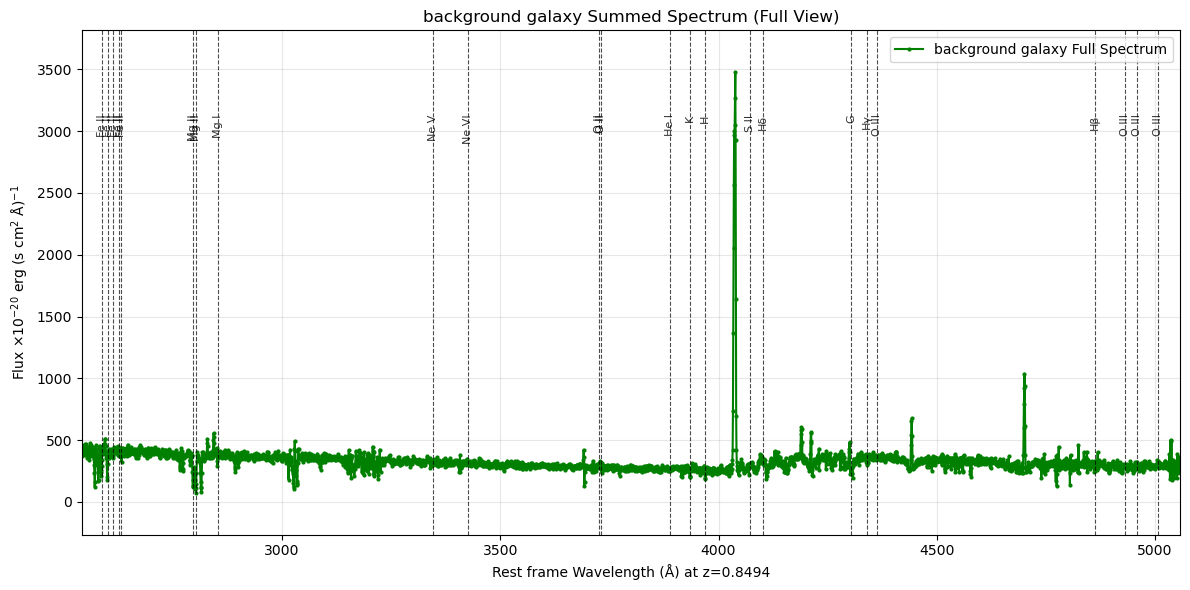

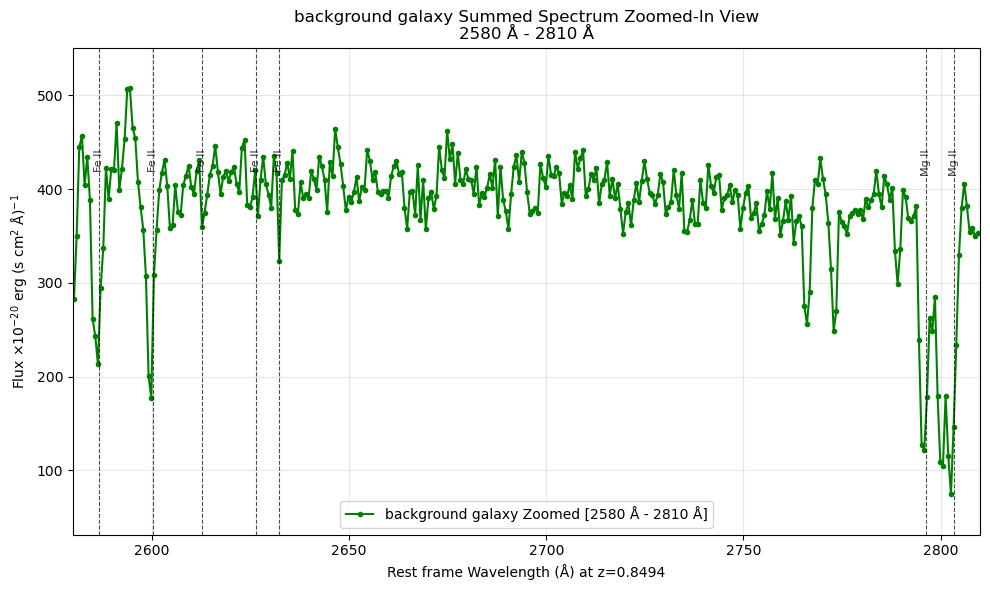

Data for intermediate galaxy II saved to C:\Users\Anwender\Desktop\M.A.G.I.C\interim processing data\intermediate_galaxy_II_summed_spectrum.csv


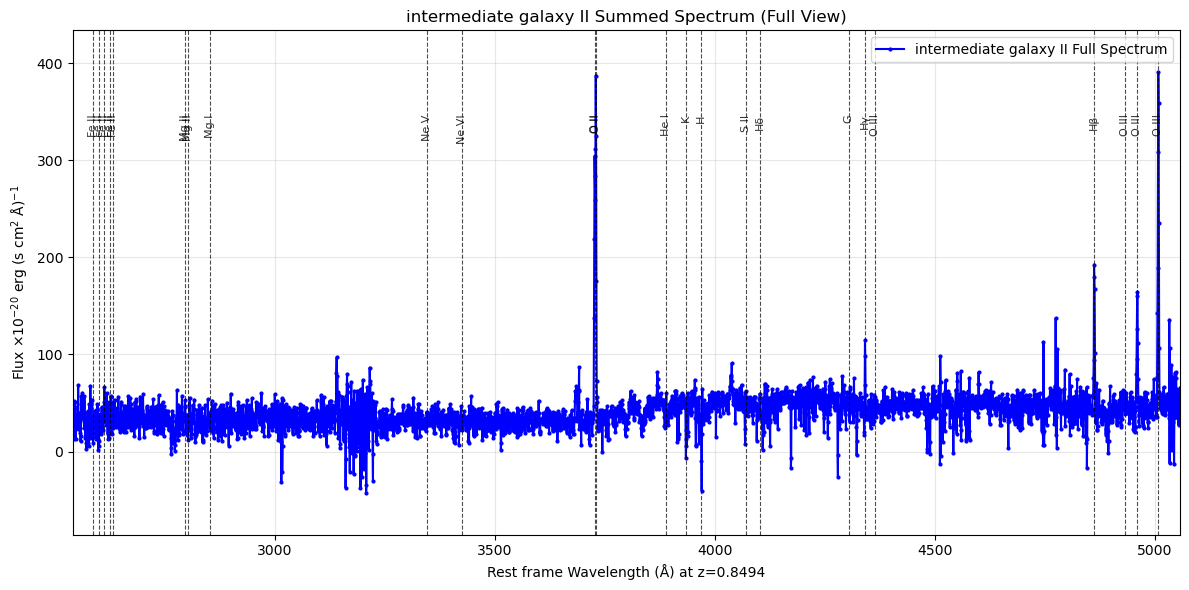

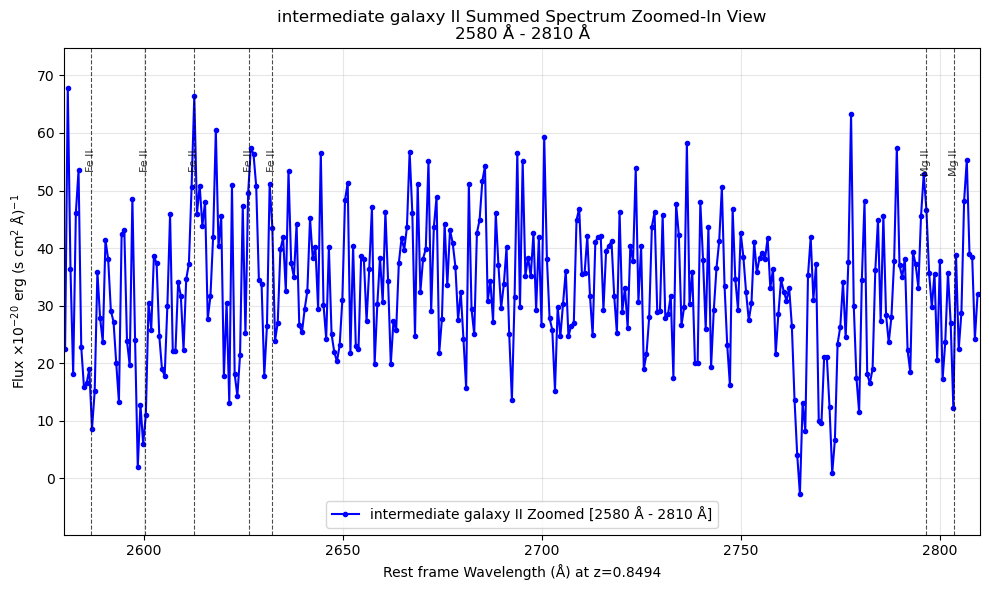

In [5]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# =========================================================
# ========== ADJUSTABLE PARAMETERS ========================
# =========================================================

# Redshift values set for each object 
REDSHIFTS = [0.8494, 0.8494]  # set to the redshift of the galaxy to be probed  

# Object labels and colors for plotting (only the two we want)
OBJECT_LABELS = ['background galaxy', 'intermediate galaxy II']
PLOT_COLORS = ['g', 'blue']

# Zoom ranges of interest (in Å)
ZOOM_RANGES = [
    (2580, 2810),
]

# Atomic lines to mark on plots (wavelength in Å, name)
ATOMIC_LINES = [
    (1907.13, 'C III'), (2325.40, 'C II'), (2438.81, 'Ne IV'), (2796.352, 'Mg II'), 
    (2803.530, 'Mg II'), (3345.80, 'Ne V'), (3425.84, 'Ne VI'), (3727.10, 'O II'), 
    (3729.86, 'O II'), (3888.65, 'He I'), (4071.48, 'S II'), (4101.74, 'Hδ'), 
    (4340.47, 'Hγ'), (4363.21, 'O III'), (4861.33, 'Hβ'), (4931.32, 'O III'), 
    (4958.97, 'O III'), (5006.84, 'O III'), (6300.30, 'O I'), (6363.78, 'O I'), 
    (6527.64, 'N I'), (6548.05, 'N II'), (6562.80, 'Hα'), (6583.43, 'N II'), 
    (6716.48, 'S II'), (6730.83, 'S II'), (3933.66, 'K'), (3968.47, 'H'), 
    (4304.05, 'G'), (5175.64, 'Mg'), (5890.66, 'Na'), (2344.21, 'Fe II'), 
    (2374.46, 'Fe II'), (2382.76, 'Fe II'), (2586.65, 'Fe II'), (2600.17, 'Fe II'),
    (2365.55, 'Fe II'), (2396.36, 'Fe II'), (2612.65, 'Fe II'), (2626.45, 'Fe II'), 
    (2632.1, 'Fe II'), (2852.96, 'Mg I'), 
]

# =============================================================================
# FUNCTION DEFINITIONS
# =============================================================================

def apply_redshift_correction(wavelength, redshift):
    """Apply redshift correction to convert observed wavelengths to rest frame."""
    return wavelength / (1 + redshift)

# =========================================================
# ========== MAIN Script ==================================
# =========================================================

# File paths
SCRIPT_DIR = os.getcwd()
INTERIM_FOLDER = os.path.join(SCRIPT_DIR, "interim processing data")
INPUT_FILE = "summed_spectra.csv"
INPUT_FILE_PATH = os.path.join(INTERIM_FOLDER, INPUT_FILE)

# Load the CSV file 
try:
    data_vacuum = pd.read_csv(INPUT_FILE_PATH)
except UnicodeDecodeError:
    print("Note: Had to use latin-1 encoding for the file")
    data_vacuum = pd.read_csv(INPUT_FILE_PATH, encoding='latin-1')
except FileNotFoundError:
    print(f"Error: File not found at {INPUT_FILE_PATH}")
    exit()

actual_labels = data_vacuum['Object Label'].unique()
print("Available object labels in data:", actual_labels)

filtered_data = data_vacuum[data_vacuum['Object Label'].isin(OBJECT_LABELS)]
print("Object labels after filtering:", filtered_data['Object Label'].unique())
print(f"Processing {len(OBJECT_LABELS)} galaxies: {OBJECT_LABELS}")

required_columns = ['Object Label', 'Wavelength (Å, vacuum)', 'Summed Pixel Value']
for col in required_columns:
    if col not in data_vacuum.columns:
        print("Columns in the DataFrame:", data_vacuum.columns)
        print(f"Error: Column '{col}' not found in the CSV file.")
        exit()

# Extract wavelength and summed pixel values
all_wavelengths = []
all_summed_values = []

for label in OBJECT_LABELS:
    label_data = filtered_data[filtered_data['Object Label'] == label]
    all_wavelengths.append(label_data['Wavelength (Å, vacuum)'].values)
    all_summed_values.append(label_data['Summed Pixel Value'].values)
    print(f"Found {len(label_data)} data points for {label}")


# Plot configuration
PLOT_CONFIG = {
    'full_figsize': (12, 6),
    'zoom_figsize': (10, 6),
    'marker_size_full': 2,
    'marker_size_zoom': 3,
    'y_padding_factor': 0.1, 
    'label_y_position_factor': 0.1,  # Position atomic line labels
    'grid_alpha': 0.3,
    'atomic_line_alpha': 0.7,
    'atomic_line_fontsize': 8,
}

# Loop for each galaxy
for i, (wavelength_obj, summed_pixel_values_obj, color, label, z) in enumerate(
    zip(all_wavelengths, all_summed_values, PLOT_COLORS, OBJECT_LABELS, REDSHIFTS)):
    
    # Apply redshift correction
    corrected_wavelength = apply_redshift_correction(wavelength_obj, z)
    
    # Save the data to CSV
    data_to_save = pd.DataFrame({
        'Corrected Wavelength (Å)': corrected_wavelength,
        'Summed Pixel Values': summed_pixel_values_obj,
        'Object Label': label,
        'Redshift': z
    })
    
    # Save to CSV file in the "interim processing data" folder
    output_filename = f"{label.strip().replace(' ', '_')}_summed_spectrum.csv"
    output_filepath = os.path.join(INTERIM_FOLDER, output_filename)
    data_to_save.to_csv(output_filepath, index=False)
    print(f"Data for {label} saved to {output_filepath}")    
        
    # =========================================================
    # ========== Spectrum Plot =================================
    # =========================================================       
            
    # --- Full Spectrum ---
    plt.figure(figsize=PLOT_CONFIG['full_figsize'])
    plt.plot(corrected_wavelength, summed_pixel_values_obj, marker='o', linestyle='-', 
             color=color, label=f'{label} Full Spectrum', 
             markersize=PLOT_CONFIG['marker_size_full'])
    
    # data range for y-axis limits
    data_min = np.nanmin(summed_pixel_values_obj)
    data_max = np.nanmax(summed_pixel_values_obj)
    data_range = data_max - data_min
    y_padding = data_range * PLOT_CONFIG['y_padding_factor']
    plt.ylim(data_min - y_padding, data_max + y_padding)
    
    # Add atomic lines to the full spectrum plot
    min_wavelength = np.min(corrected_wavelength)
    max_wavelength = np.max(corrected_wavelength)
    
    for line_wavelength, line_name in ATOMIC_LINES:
        if min_wavelength <= line_wavelength <= max_wavelength:
            plt.axvline(x=line_wavelength, color='k', linestyle='--', 
                       linewidth=0.8, alpha=PLOT_CONFIG['atomic_line_alpha'])
            # Position the label within the data range
            label_y_pos = data_max - (data_range * PLOT_CONFIG['label_y_position_factor'])
            plt.text(line_wavelength, label_y_pos, line_name, 
                     rotation=90, verticalalignment='top', horizontalalignment='center', 
                     fontsize=PLOT_CONFIG['atomic_line_fontsize'], alpha=0.8)
    
    # Set x-axis limits
    plt.xlim(min_wavelength, max_wavelength)
    
    # plot labels and title
    plt.xlabel(f'Rest frame Wavelength (Å) at z={z}')
    plt.ylabel(r'Flux $\times 10^{-20}$ erg (s cm$^{2}$ Å)$^{-1}$')
    plt.title(f'{label} Summed Spectrum (Full View)')
    plt.grid(True, alpha=PLOT_CONFIG['grid_alpha'])
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    # --- Zoomed Spectrum ---
    for zoom_range in ZOOM_RANGES:
        zoom_mask = (corrected_wavelength >= zoom_range[0]) & (corrected_wavelength <= zoom_range[1])
        finite_mask = np.isfinite(corrected_wavelength[zoom_mask]) & np.isfinite(summed_pixel_values_obj[zoom_mask])
        
        if np.any(finite_mask):
            plt.figure(figsize=PLOT_CONFIG['zoom_figsize'])
            

            plt.plot(corrected_wavelength[zoom_mask][finite_mask], 
                     summed_pixel_values_obj[zoom_mask][finite_mask], 
                     marker='o', linestyle='-', color=color, 
                     label=f'{label} Zoomed [{zoom_range[0]} Å - {zoom_range[1]} Å]',
                     markersize=PLOT_CONFIG['marker_size_zoom'])
            
            plt.xlim(zoom_range[0], zoom_range[1])

            # y-limits for zoomed plot
            zoom_data = summed_pixel_values_obj[zoom_mask][finite_mask]
            if len(zoom_data) > 0:
                zoom_min = np.nanmin(zoom_data)
                zoom_max = np.nanmax(zoom_data)
                zoom_range_y = zoom_max - zoom_min
                plt.ylim(zoom_min - zoom_range_y * PLOT_CONFIG['y_padding_factor'], 
                         zoom_max + zoom_range_y * PLOT_CONFIG['y_padding_factor'])

            #  atomic lines within zoomed plot
            for line_wavelength, line_name in ATOMIC_LINES:
                if zoom_range[0] <= line_wavelength <= zoom_range[1]:
                    plt.axvline(x=line_wavelength, color='k', linestyle='--', 
                               linewidth=0.8, alpha=PLOT_CONFIG['atomic_line_alpha'])
                    if len(zoom_data) > 0:
                        label_y_pos = zoom_max - (zoom_range_y * 0.15)
                        plt.text(line_wavelength, label_y_pos, line_name, 
                                 rotation=90, verticalalignment='top', horizontalalignment='center', 
                                 fontsize=PLOT_CONFIG['atomic_line_fontsize'], alpha=0.8)

            plt.xlabel(f'Rest frame Wavelength (Å) at z={z}')
            plt.ylabel(r'Flux $\times 10^{-20}$ erg [s cm$^{2}$ Å]$^{-1}$')
            plt.title(f'{label} Summed Spectrum Zoomed-In View\n{zoom_range[0]} Å - {zoom_range[1]} Å')
            plt.grid(True, alpha=PLOT_CONFIG['grid_alpha'])
            plt.tight_layout()
            plt.legend()
            plt.show()

# STEP G Continuum Fitting

Starting spectrum processing...
Loaded: interim processing data\background_galaxy_summed_spectrum.csv
Shape: (3722, 4), Columns: ['Corrected Wavelength (Å)', 'Summed Pixel Values', 'Object Label', 'Redshift']
Data ranges: λ=2541.7-5057.2Å, Flux=74.650-3475.608
Filter width: 1.9 samples

DATA POINT REJECTION STATISTICS
Total data points: 3722
Points rejected due to slope: 870 (23.4%)
Points rejected due to curvature: 2381 (64.0%)
Points rejected by both criteria: 695 (18.7%)
Total masked points: 2556 (68.7%)
Continuum points remaining: 1166 (31.3%)
Continuum statistics: Mean=1.000, Std=0.043
Used 1166/3722 points (31.3%)
Results saved: interim processing data\fitted_spectrum.csv
Plot saved: interim processing data\continuum_fit_results.jpg


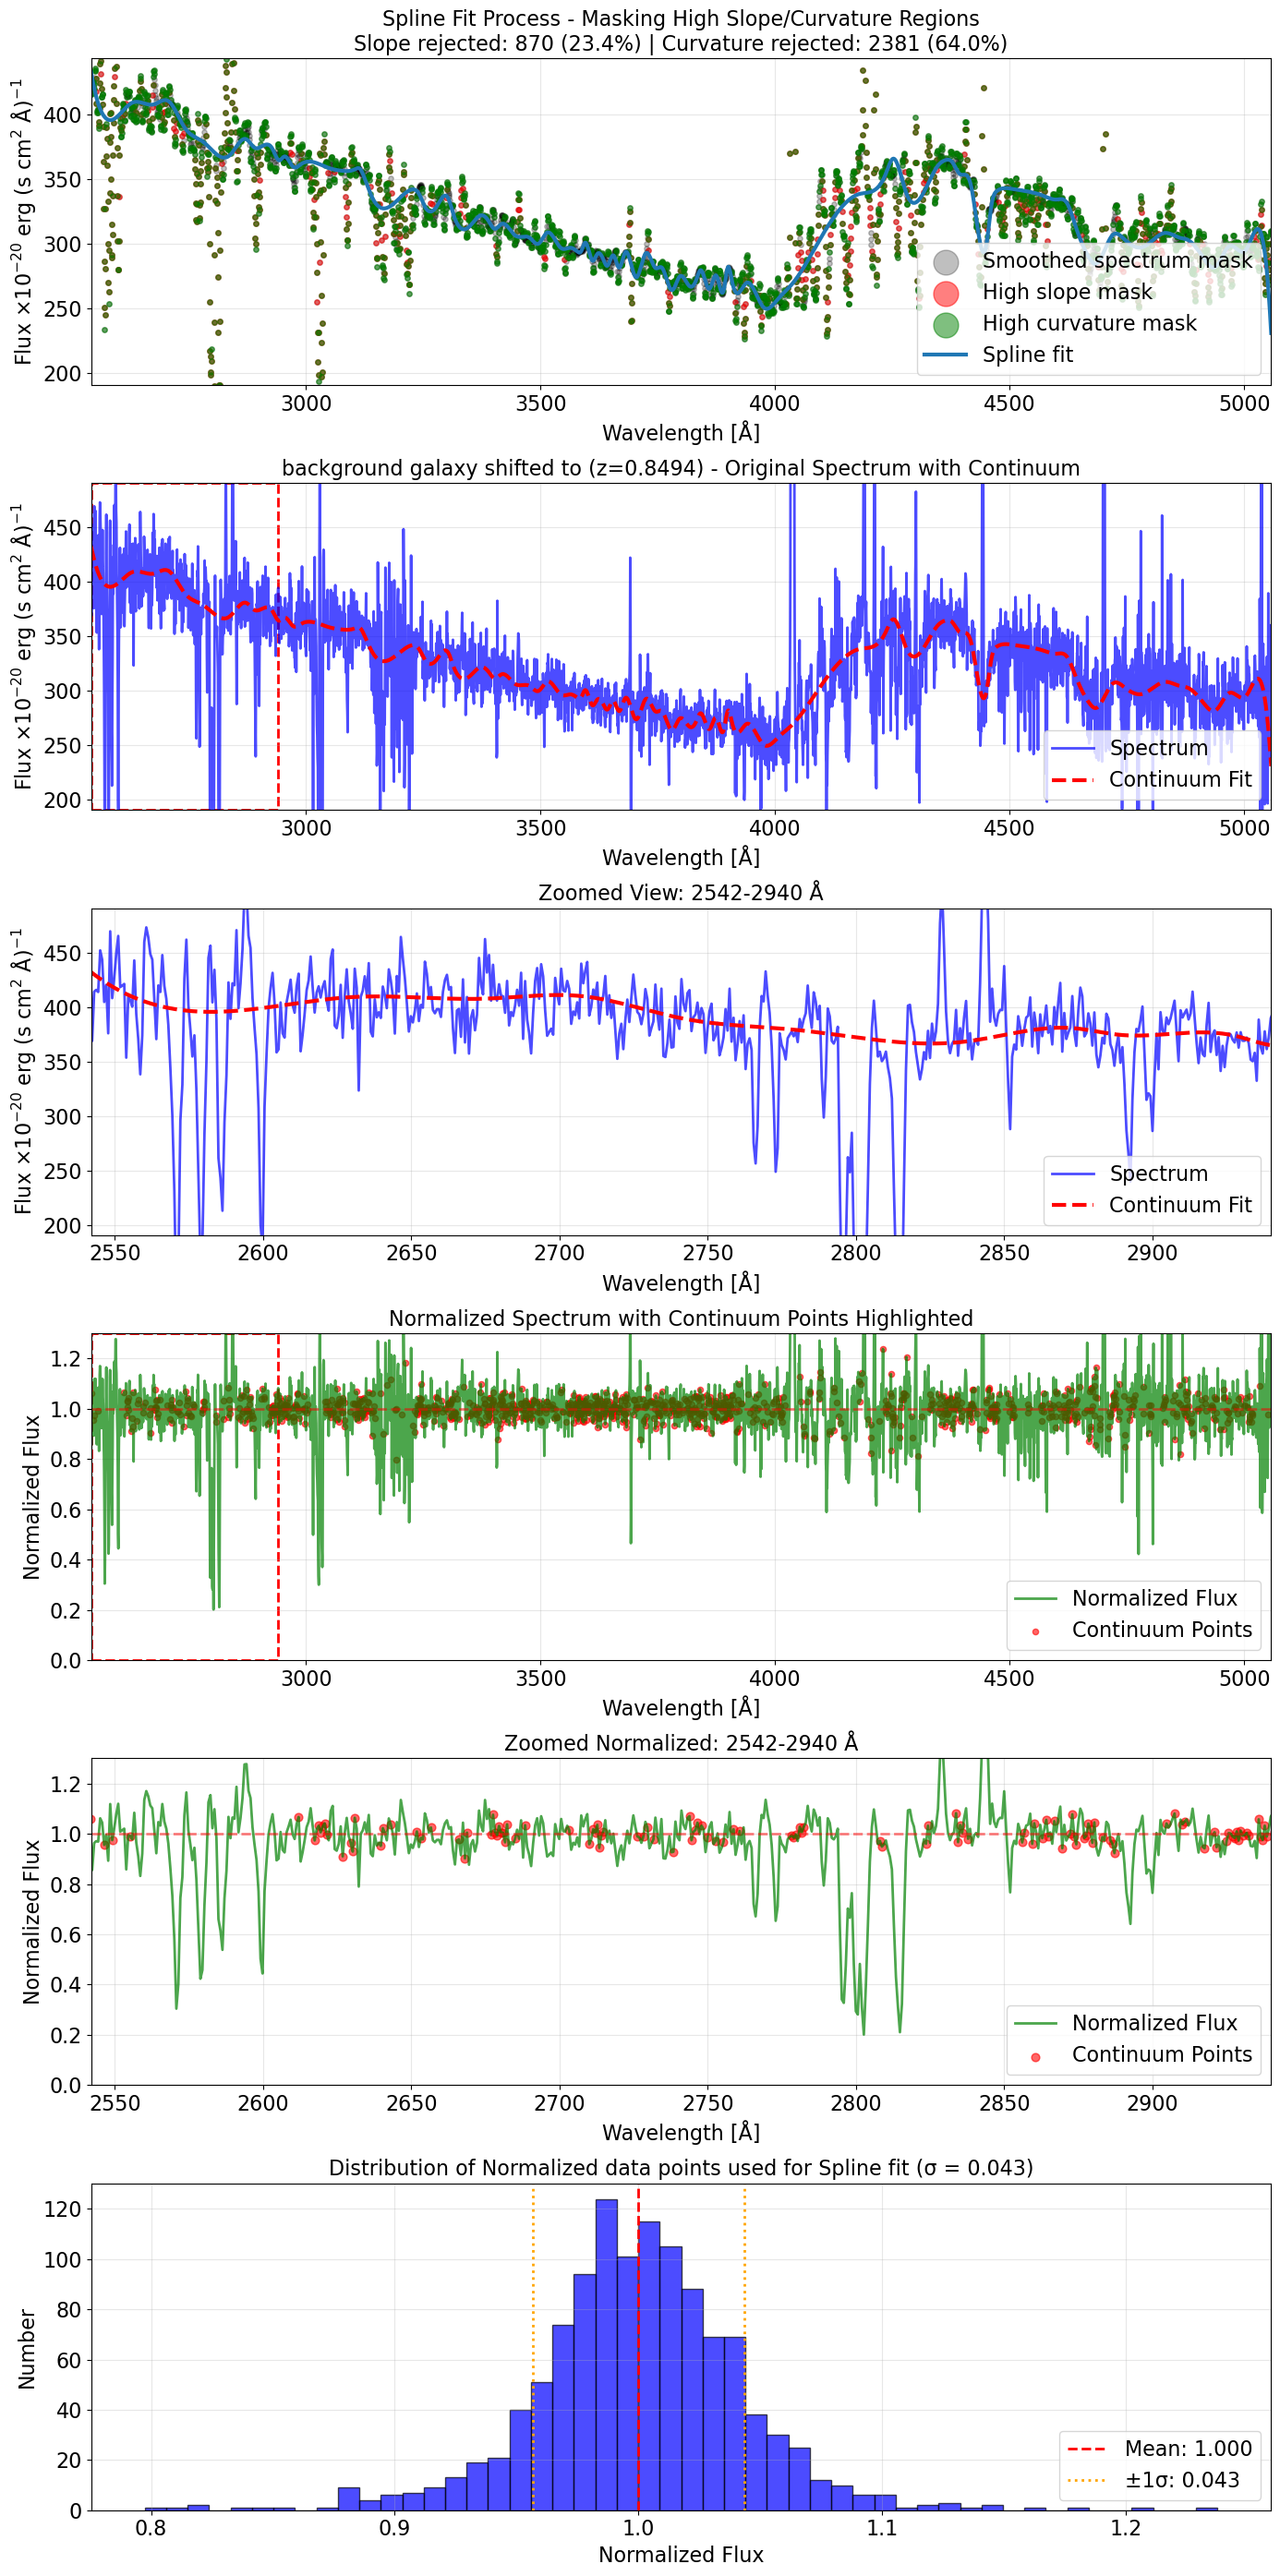


PROCESSING COMPLETE
Continuum points: 1166/3722 (31.3%)
Normalized flux - Mean: 1.0000, Std: 0.0435


In [6]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
import astropy.constants as c
from scipy.ndimage import maximum_filter1d, gaussian_filter1d
from scipy.interpolate import splrep, BSpline
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# =========================================================
# ========== ADJUSTABLE PARAMETERS ========================
# =========================================================



DATA_FILE = os.path.join("interim processing data", "background_galaxy_summed_spectrum.csv")
WAVELENGTH_COL = 'Corrected Wavelength (Å)'
FLUX_COL = 'Summed Pixel Values'

CONFIG = {
    'fitting': {
        'filter_width': 100.0 * u.km / u.s,               #velocity space smothing 
                                                          #lower values mean more aggressive smoothing but the continuum may include narrow aborbiton lines
        'filter_threshold': (8, 80),                      #slope and curvature parameters 
                                                          #higher numbers mean -> fewer data points masked out
        'samples_per_stencil': None,
    },
    'output': {
        'debug': True,
        'create_plots': True,
        'save_results': True,
        'output_file': "fitted_spectrum.csv",
        'plot_format': '.jpg',
        'show_plots': True,
    }
}


# =========================================================
# === Smoothing Kernel Continuum Fit ======================
# =========================================================

"""
Smoothing Kernel Continuum Fit change, based on the work of M. Sc. Florian Ruegner.

This function performs automatic continuum normalization on spectral data using a 
smoothing kernel approach. The Idea behind the method:

Applies Gaussian smoothing to identify the baseline continuum less influenced by noise
Then Computes gradient and curvature masks to detect narrow absorption/emission features in the spectra
Masks data ponts over curvutuore and threshold value, to these spectral features from continuum fitting
Fits a B-spline to the unmasked continuum regions wich the data is normalized against.

Outputs are: continuum spline, normalized flux standard deviation, and unmasked indices """

def SK_cont_fit(x_D, y_D, filter_width=50. * u.km / u.s, **kwargs):
    """Smoothing Kernel continuum fit"""
    
    # STEP 1: Convert filter width from physical units to number of samples
    if isinstance(filter_width, u.Quantity):
        filter_width = (filter_width / c.c * np.mean(x_D)).to_value(1) / np.mean(x_D[1:] - x_D[:-1])
    
    if CONFIG['output']['debug']:
        print(f"Filter width: {filter_width:.1f} samples")
    
    # STEP 2: Apply Gaussian smoothing and compute derivatives
    filtered_y_D = gaussian_filter1d(y_D, filter_width)
    grad_y_D = np.gradient(filtered_y_D, x_D)
    gradgrad_y_D = np.gradient(grad_y_D, x_D)
    
    # STEP 3: Calculate thresholds for masking absorption features
    if "absorption_percentage" in kwargs:
        perc = kwargs["absorption_percentage"]
        thres_grad = np.percentile(np.abs(grad_y_D - np.mean(grad_y_D)), q=100 - perc[0])
        thres_curv = np.percentile(np.abs(gradgrad_y_D - np.mean(gradgrad_y_D)), q=100 - perc[1])
    else:
        # Use default or provided threshold values
        thres_grad, thres_curv = kwargs.get("filter_threshold", (2, 20))
        # Normalize curvature threshold using a reference Gaussian shape
        thres_curv *= np.gradient(np.gradient(
            gaussian_filter1d(0.5 * np.arange(-np.ceil(filter_width), np.ceil(filter_width))**2, filter_width)
        ))[int(np.ceil(filter_width))]
    
    # STEP 4: Create and masks to for absorption regions
    mask_grad = np.abs(grad_y_D - np.mean(grad_y_D)) > thres_grad
    mask_curv = np.abs(gradgrad_y_D - np.mean(gradgrad_y_D)) > thres_curv
    
    # Apply maximum filter to both masks separately before combining
    mask_grad_filtered = maximum_filter1d(mask_grad, int(np.floor(filter_width)))
    mask_curv_filtered = maximum_filter1d(mask_curv, int(np.floor(filter_width)))
    masked_ids = mask_grad_filtered | mask_curv_filtered
    
    # indices of continuum points
    unmasked_ids = ~masked_ids
    
    # Calculate rejection statistics
    total_points = len(masked_ids)
    rejected_slope = mask_grad_filtered.sum()
    rejected_curvature = mask_curv_filtered.sum()
    rejected_both = (mask_grad_filtered & mask_curv_filtered).sum()
    
    # REMOVED the debug printing from here to avoid duplicates
    
    # STEP 5: Prepare for spline fitting
    samples_per_stencil = kwargs.get('samples_per_stencil')
    if samples_per_stencil is None:
        samples_per_stencil = filter_width * 20
    number_of_knots = max(3, int(x_D.size / samples_per_stencil))
    if x_D[unmasked_ids].size < number_of_knots + 2:
        raise ValueError(f"Insufficient unmasked points. Need {number_of_knots + 2} but only have {x_D[unmasked_ids].size}")
    
    # STEP 7: Fit spline to continuum masked points 
    tck = splrep(
        x_D[unmasked_ids],          
        y_D[unmasked_ids],           
        t=np.percentile(x_D[unmasked_ids], q=np.linspace(0, 100, number_of_knots))[1:-1],  # evenly knots placement 
        task=-1                     
    )
    
    # STEP 8: Create spline "function" and normalize flux tospline
    spline = BSpline(*tck)
    normalized_flux = y_D / spline(x_D)
    std_normalized = np.std(normalized_flux[unmasked_ids])
    
    # Return additional statistics
    rejection_stats = {
        'total_points': total_points,
        'rejected_slope': rejected_slope,
        'rejected_curvature': rejected_curvature,
        'rejected_both': rejected_both,
        'masked_total': masked_ids.sum(),
        'unmasked_total': unmasked_ids.sum()
    }
    
    return spline, std_normalized, unmasked_ids, rejection_stats

# =========================================================
# === Plotting function ===================================
# =========================================================

def create_plots(x_D, y_D, spline_fit, unmasked_ids, std_normalized, df, output_dir, rejection_stats=None):
    """Create analysis plots for continuum fitting results,
    (can be usefull to validty/quality of the fit)"""
    
    #global font sizes
    title_fontsize = 16
    label_fontsize = 16
    legend_fontsize = 16
    tick_fontsize = 16
    
    # zooming wavelength range for prominent MgII and Fe II lines  
    zoom_min_wavelength = 2542  
    zoom_max_wavelength = 2940 
    
    # Normalize flux 
    y_norm = y_D / spline_fit(x_D)
    
    redshift = df['Redshift'].iloc[0] if 'Redshift' in df.columns else 0.0
    object_label = df['Object Label'].iloc[0] if 'Object Label' in df.columns else "Spectrum"
    fig, (ax0, ax1, ax2, ax3, ax4, ax5) = plt.subplots(6, 1, figsize=(14, 28))  
     
    filter_width = CONFIG['fitting']['filter_width']
    if isinstance(filter_width, u.Quantity):
        filter_width = (filter_width / c.c * np.mean(x_D)).to_value(1) / np.mean(x_D[1:] - x_D[:-1])
    
    filtered_y_D = gaussian_filter1d(y_D, filter_width)
    grad_y_D = np.gradient(filtered_y_D, x_D)
    gradgrad_y_D = np.gradient(grad_y_D, x_D)
    
    thres_grad, thres_curv = CONFIG['fitting']['filter_threshold']
    thres_curv *= np.gradient(np.gradient(
        gaussian_filter1d(0.5 * np.arange(-np.ceil(filter_width), np.ceil(filter_width))**2, filter_width)
    ))[int(np.ceil(filter_width))]
    
    mask_grad = np.abs(grad_y_D - np.mean(grad_y_D)) > thres_grad
    mask_curv = np.abs(gradgrad_y_D - np.mean(gradgrad_y_D)) > thres_curv
    mask_grad = maximum_filter1d(mask_grad, int(np.floor(filter_width)))
    mask_curv = maximum_filter1d(mask_curv, int(np.floor(filter_width)))
    
    # Plot 1: Spline fit process
    
    ax0.scatter(x_D, filtered_y_D, c="k", s=15, zorder=0, alpha=0.25, label="Smoothed spectrum mask")  
    ax0.scatter(x_D[mask_grad], filtered_y_D[mask_grad], zorder=2, c="red", s=15, alpha=0.5, label="High slope mask")  
    ax0.scatter(x_D[mask_curv], filtered_y_D[mask_curv], zorder=2, c="green", s=15, alpha=0.5, label="High curvature mask")  
    ax0.plot(x_D, spline_fit(x_D), lw=3, color="tab:blue", label="Spline fit") 
    ax0.set_ylim(np.percentile(y_D, 1), np.percentile(y_D, 98))
    ax0.set_xlim(np.min(x_D), np.max(x_D))
    
    # rejection/debug statistics
    if rejection_stats is not None:
        title = (f"Spline Fit Process - Masking High Slope/Curvature Regions\n"
                f"Slope rejected: {rejection_stats['rejected_slope']} ({100*rejection_stats['rejected_slope']/rejection_stats['total_points']:.1f}%) | "
                f"Curvature rejected: {rejection_stats['rejected_curvature']} ({100*rejection_stats['rejected_curvature']/rejection_stats['total_points']:.1f}%)")
    else:
        title = "Spline Fit Process - Masking High Slope/Curvature Regions"
    
    ax0.set_title(title, fontsize=title_fontsize)
    ax0.set_ylabel(r'Flux $\times 10^{-20}$ erg [s cm$^{2}$ Å]$^{-1}$', fontsize=label_fontsize)
    ax0.set_xlabel('Wavelength [Å]', fontsize=label_fontsize)
    ax0.legend(markerscale=5, fontsize=legend_fontsize, loc='lower right')
    ax0.grid(True, alpha=0.3)
    ax0.tick_params(axis='both', which='major', labelsize=tick_fontsize)
    
    

    # Plot 2: Original spectrum with spline continuum fit
    ax1.plot(x_D, y_D, 'b-', alpha=0.7, linewidth=2, label='Spectrum')  
    ax1.plot(x_D, spline_fit(x_D), 'r--', linewidth=3, label='Continuum Fit')  
    ax1.set_ylabel(r'Flux $\times 10^{-20}$ erg [s cm$^{2}$ Å]$^{-1}$', fontsize=label_fontsize)
    ax1.set_xlabel('Wavelength [Å]', fontsize=label_fontsize)
    ax1.set_title(f'{object_label} shifted to (z={redshift:.4f}) - Original Spectrum with Continuum', fontsize=title_fontsize)
    ax1.legend(fontsize=legend_fontsize, loc='lower right')
    ax1.grid(True, alpha=0.3)
    ax1.tick_params(axis='both', which='major', labelsize=tick_fontsize)

    
    y_min = np.percentile(y_D, 1)
    y_max = np.percentile(y_D, 99)
    ax1.set_ylim(y_min, y_max)
    ax1.set_xlim(np.min(x_D), np.max(x_D))
    zoom_x_range = [zoom_min_wavelength, zoom_max_wavelength]
    zoom_y_range = [y_min, y_max]  

    rect = plt.Rectangle((zoom_x_range[0], zoom_y_range[0]), 
                        zoom_x_range[1]-zoom_x_range[0], 
                        zoom_y_range[1]-zoom_y_range[0],
                        fill=False, color='red', linestyle='--', linewidth=2)  
    ax1.add_patch(rect)

    # Plot 3: Zoomed-in view
    ax2.plot(x_D, y_D, 'b-', alpha=0.7, linewidth=2, label='Spectrum')  
    ax2.plot(x_D, spline_fit(x_D), 'r--', linewidth=3, label='Continuum Fit')  
    ax2.set_xlim(zoom_x_range)
    ax2.set_ylim(zoom_y_range)  
    ax2.set_ylabel(r'Flux $\times 10^{-20}$ erg [s cm$^{2}$ Å]$^{-1}$', fontsize=label_fontsize)
    ax2.set_xlabel('Wavelength [Å]', fontsize=label_fontsize)
    ax2.set_title(f'Zoomed View: {zoom_min_wavelength}-{zoom_max_wavelength} Å', fontsize=title_fontsize)
    ax2.legend(fontsize=legend_fontsize, loc='lower right')
    ax2.grid(True, alpha=0.3)
    ax2.tick_params(axis='both', which='major', labelsize=tick_fontsize)

    # Plot 4: Normalized spectrum
    ax3.plot(x_D, y_norm, 'g-', alpha=0.7, linewidth=2, label='Normalized Flux')  
    ax3.scatter(x_D[unmasked_ids], y_norm[unmasked_ids], c='red', s=20, alpha=0.6, label='Continuum Points') 
    ax3.axhline(1.0, color='red', linestyle='--', alpha=0.5, linewidth=2)  
    ax3.set_ylabel('Normalized Flux', fontsize=label_fontsize)
    ax3.set_xlabel('Wavelength [Å]', fontsize=label_fontsize)
    ax3.set_title('Normalized Spectrum with Continuum Points Highlighted', fontsize=title_fontsize)
    ax3.set_ylim(0, 1.3)
    ax3.set_xlim(np.min(x_D), np.max(x_D))
    ax3.legend(fontsize=legend_fontsize, loc='lower right')
    ax3.grid(True, alpha=0.3)
    ax3.tick_params(axis='both', which='major', labelsize=tick_fontsize)

    rect_norm = plt.Rectangle((zoom_x_range[0], 0), 
                             zoom_x_range[1]-zoom_x_range[0], 
                             1.3,  
                             fill=False, color='red', linestyle='--', linewidth=2)  
    ax3.add_patch(rect_norm)

    # Plot 5: Zoomed-in view
    ax4.plot(x_D, y_norm, 'g-', alpha=0.7, linewidth=2, label='Normalized Flux')  
    ax4.scatter(x_D[unmasked_ids], y_norm[unmasked_ids], c='red', s=40, alpha=0.6, label='Continuum Points')  
    ax4.axhline(1.0, color='red', linestyle='--', alpha=0.5, linewidth=2)
    ax4.set_xlim(zoom_x_range)
    ax4.set_ylim(0, 1.3) 
    ax4.set_xlabel('Wavelength [Å]', fontsize=label_fontsize)
    ax4.set_ylabel('Normalized Flux', fontsize=label_fontsize)
    ax4.set_title(f'Zoomed Normalized: {zoom_min_wavelength}-{zoom_max_wavelength} Å', fontsize=title_fontsize)
    ax4.legend(fontsize=legend_fontsize, loc='lower right')
    ax4.grid(True, alpha=0.3)
    ax4.tick_params(axis='both', which='major', labelsize=tick_fontsize)

    # Plot 6: Continuum spectrum uncertainty
    continuum_flux = y_norm[unmasked_ids]
    ax5.hist(continuum_flux, bins=50, alpha=0.7, color='blue', edgecolor='black')
    mean_flux = np.mean(continuum_flux)
    ax5.axvline(mean_flux, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_flux:.3f}') 
    ax5.axvline(mean_flux + std_normalized, color='orange', linestyle=':', linewidth=2, label=f'±1σ: {std_normalized:.3f}')  
    ax5.axvline(mean_flux - std_normalized, color='orange', linestyle=':', linewidth=2)  
    ax5.set_xlabel('Normalized Flux', fontsize=label_fontsize)
    ax5.set_ylabel('Number', fontsize=label_fontsize)
    ax5.set_title(f'Distribution of Normalized data points used for Spline fit (σ = {std_normalized:.3f})', fontsize=title_fontsize)
    ax5.legend(fontsize=legend_fontsize, loc='lower right')
    ax5.grid(True, alpha=0.3)
    ax5.tick_params(axis='both', which='major', labelsize=tick_fontsize)

    plt.tight_layout()

    if CONFIG['output']['save_results']:
        plot_file = os.path.join(output_dir, f"continuum_fit_results{CONFIG['output']['plot_format']}")
        plt.savefig(plot_file, dpi=300, bbox_inches='tight')
        print(f"Plot saved: {plot_file}")

    if CONFIG['output']['show_plots']:
        plt.show()

"""
Main processing. Aplies continuum normalization on data.

Loads spectrum data, fits continuum using  spline,
masks spectral features, and returns normalized flux with statistics.
"""
        
def process_spectrum():
    try:
        if not os.path.exists(DATA_FILE):
            raise FileNotFoundError(f"Data file not found: {DATA_FILE}")
        
        df = pd.read_csv(DATA_FILE)
        print(f"Loaded: {DATA_FILE}")
        print(f"Shape: {df.shape}, Columns: {list(df.columns)}")
        
        # Validate specified columns exist
        if WAVELENGTH_COL not in df.columns:
            raise ValueError(f"Wavelength column '{WAVELENGTH_COL}' not found in data file")
        if FLUX_COL not in df.columns:
            raise ValueError(f"Flux column '{FLUX_COL}' not found in data file")
        
        x_D, y_D = df[WAVELENGTH_COL].values, df[FLUX_COL].values
        print(f"Data ranges: λ={x_D.min():.1f}-{x_D.max():.1f}Å, Flux={y_D.min():.3f}-{y_D.max():.3f}")
        
        output_dir = os.path.dirname(DATA_FILE) or "."  
        
    except Exception as e:
        print(f"Error loading data: {e}")
        return None
    
    # apply SK_cont_fit continuum 
    try:
        spline_fit, std_normalized, unmasked_ids, rejection_stats = SK_cont_fit(
            x_D, y_D, 
            filter_width=CONFIG['fitting']['filter_width'],
            filter_threshold=CONFIG['fitting']['filter_threshold'],
            samples_per_stencil=CONFIG['fitting']['samples_per_stencil']
        )
    except Exception as e:
        print(f"Error in continuum fitting: {e}")
        return None
    
    # Print processing statistics 
    print("\n" + "="*60)
    print("DATA POINT REJECTION STATISTICS")
    print("="*60)
    print(f"Total data points: {rejection_stats['total_points']}")
    print(f"Points rejected due to slope: {rejection_stats['rejected_slope']} ({100*rejection_stats['rejected_slope']/rejection_stats['total_points']:.1f}%)")
    print(f"Points rejected due to curvature: {rejection_stats['rejected_curvature']} ({100*rejection_stats['rejected_curvature']/rejection_stats['total_points']:.1f}%)")
    print(f"Points rejected by both criteria: {rejection_stats['rejected_both']} ({100*rejection_stats['rejected_both']/rejection_stats['total_points']:.1f}%)")
    print(f"Total masked points: {rejection_stats['masked_total']} ({100*rejection_stats['masked_total']/rejection_stats['total_points']:.1f}%)")
    print(f"Continuum points remaining: {rejection_stats['unmasked_total']} ({100*rejection_stats['unmasked_total']/rejection_stats['total_points']:.1f}%)")
    print("="*60)
    y_norm = y_D / spline_fit(x_D)
    continuum_flux = y_norm[unmasked_ids]
    stats = {
        'mean': np.mean(continuum_flux),
        'std': std_normalized,
        'median': np.median(continuum_flux),
        'continuum_points': unmasked_ids.sum(),
        'total_points': len(unmasked_ids),
    }
    stats['continuum_fraction'] = 100 * stats['continuum_points'] / stats['total_points']
    
    print(f"Continuum statistics: Mean={stats['mean']:.3f}, Std={stats['std']:.3f}")
    print(f"Used {stats['continuum_points']}/{stats['total_points']} points ({stats['continuum_fraction']:.1f}%)")
    
    # Save results
    if CONFIG['output']['save_results']:
        try:
            output_df = pd.DataFrame({
                "Wavelength": x_D,
                "Flux": y_D,
                "Spline_Fit": spline_fit(x_D),
                "Normalized_Flux": y_norm,
                "Is_Continuum": unmasked_ids
            })
            output_file = os.path.join(output_dir, CONFIG['output']['output_file'])
            output_df.to_csv(output_file, index=False)
            print(f"Results saved: {output_file}")
        except Exception as e:
            print(f"Error saving results: {e}")
    
    # Create plots
    if CONFIG['output']['create_plots']:
        try:
            create_plots(x_D, y_D, spline_fit, unmasked_ids, std_normalized, df, output_dir, rejection_stats)
        except Exception as e:
            print(f"Error creating plots: {e}")
    
    return output_df, spline_fit, stats, rejection_stats


# confirmation if processing is complete
if __name__ == "__main__":
    print("Starting spectrum processing...")
    results = process_spectrum()
    
    if results:
        output_df, spline_fit, stats, rejection_stats = results
        print("\n" + "="*50)
        print("PROCESSING COMPLETE")
        print("="*50)
        print(f"Continuum points: {stats['continuum_points']}/{stats['total_points']} ({stats['continuum_fraction']:.1f}%)")
        print(f"Normalized flux - Mean: {stats['mean']:.4f}, Std: {stats['std']:.4f}")
        print("="*50)
    else:
        print("Processing failed.")

# Inspection if second iteration (STEP H) is needed

Filtered and grouped plotted data points saved to: C:\Users\Anwender\Desktop\M.A.G.I.C\interim processing data\plotted_data_points_grouped_wavelength.csv


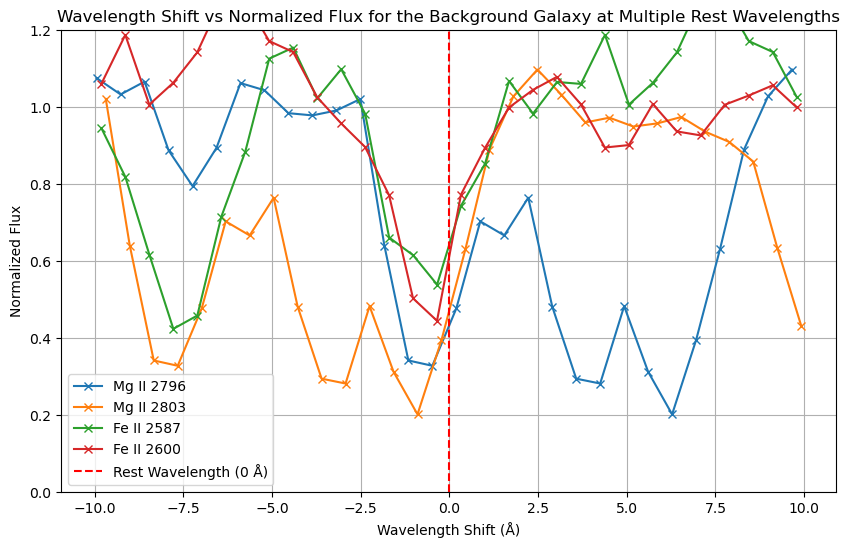

Plot saved to: C:\Users\Anwender\Desktop\M.A.G.I.C\interim processing data\wavelength_shift_intensity_multiple_lines.png


<Figure size 640x480 with 0 Axes>

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# Mg II and Fe II absorbtion lines of interest ad and remove on a case by case basis include and axlude based on spectral range and signal quality
line_labels = {
    2796.352: 'Mg II 2796',
    2803.530: 'Mg II 2803',
    2586.649: 'Fe II 2587',
    2600.172: 'Fe II 2600',
    #2382.764: 'Fe II 2383',
    #2374.460: 'Fe II 2374',
    #2344.213: 'Fe II 2344',
}


#loading data
script_dir = os.getcwd()
file_path_background = os.path.join(script_dir, r"interim processing data\fitted_spectrum.csv")
data_background = pd.read_csv(file_path_background)


# Wavelength range limit around each rest wavelength
rest_wavelengths = list(line_labels.keys())
wavelength_range = 10  # Å
all_filtered_data = []
 
plt.figure(figsize=(10, 6))
plt.ylim(0, 1.2)


# Loop for each line
for rest_wavelength in rest_wavelengths:
    filtered_data = data_background[
        (data_background['Wavelength'] >= rest_wavelength - wavelength_range) &
        (data_background['Wavelength'] <= rest_wavelength + wavelength_range)
    ].copy()  
    
    # rest wavelength is at 0
    filtered_data.loc[:, 'Wavelength Shift (Å)'] = filtered_data['Wavelength'] - rest_wavelength
    
    # Add columnsto csv identifying the specific atomic line and keep original columns
    filtered_data.loc[:, 'Rest Wavelength (Å)'] = rest_wavelength
    filtered_data = filtered_data.rename(columns={'Normalized_Flux': 'Normalized Flux'})
    filtered_data = filtered_data[['Rest Wavelength (Å)', 'Wavelength Shift (Å)', 'Normalized Flux']]
    
    all_filtered_data.append(filtered_data)
    label = line_labels.get(rest_wavelength, f'{rest_wavelength} Å')
    
    plt.plot(filtered_data['Wavelength Shift (Å)'], 
             filtered_data['Normalized Flux'], 
             marker='x', linestyle='-', label=label)

    

combined_filtered_data = pd.concat(all_filtered_data, ignore_index=True)

# Save  CSV file
output_file_path = os.path.join(script_dir, r"interim processing data\plotted_data_points_grouped_wavelength.csv")
combined_filtered_data.to_csv(output_file_path, index=False)
print(f"Filtered and grouped plotted data points saved to: {output_file_path}")

plt.axvline(0, color='red', linestyle='--', label='Rest Wavelength (0 Å)')
plt.xlabel('Wavelength Shift (Å)')
plt.ylabel('Normalized Flux')
plt.title('Wavelength Shift vs Normalized Flux for the Background Galaxy at Multiple Rest Wavelengths')
plt.legend()
plt.grid()


plt.show()

# save plot
plot_file_path = os.path.join(script_dir, r"interim processing data\wavelength_shift_intensity_multiple_lines.png")
plt.savefig(plot_file_path)
print(f"Plot saved to: {plot_file_path}")

# STEP H a Second itteration of continuum fitting

100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:11<00:00, 445.21it/s]


Best-fit parameters:
Amplitude 1: 0.7110
Mean 1: -0.5733 Å
Sigma 1: 1.0044 Å
Amplitude 2: 0.6833
Mean 2: 3.7869 Å
Sigma 2: 1.2450 Å
Amplitude 3: 0.7015
Mean 3: 6.5109 Å
Sigma 3: 0.9022 Å


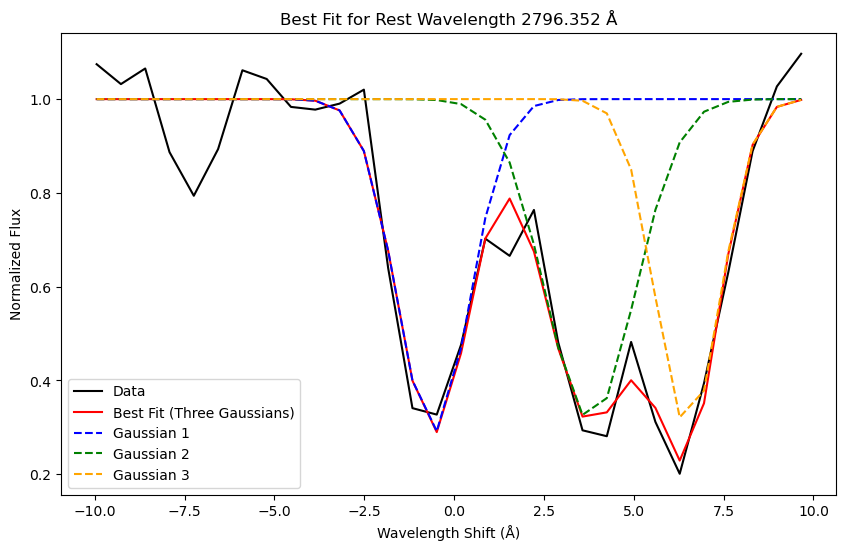

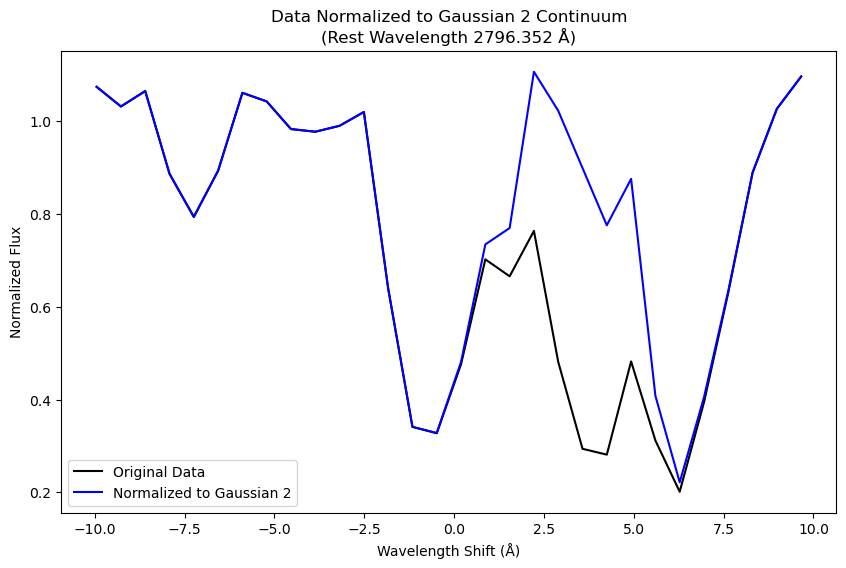

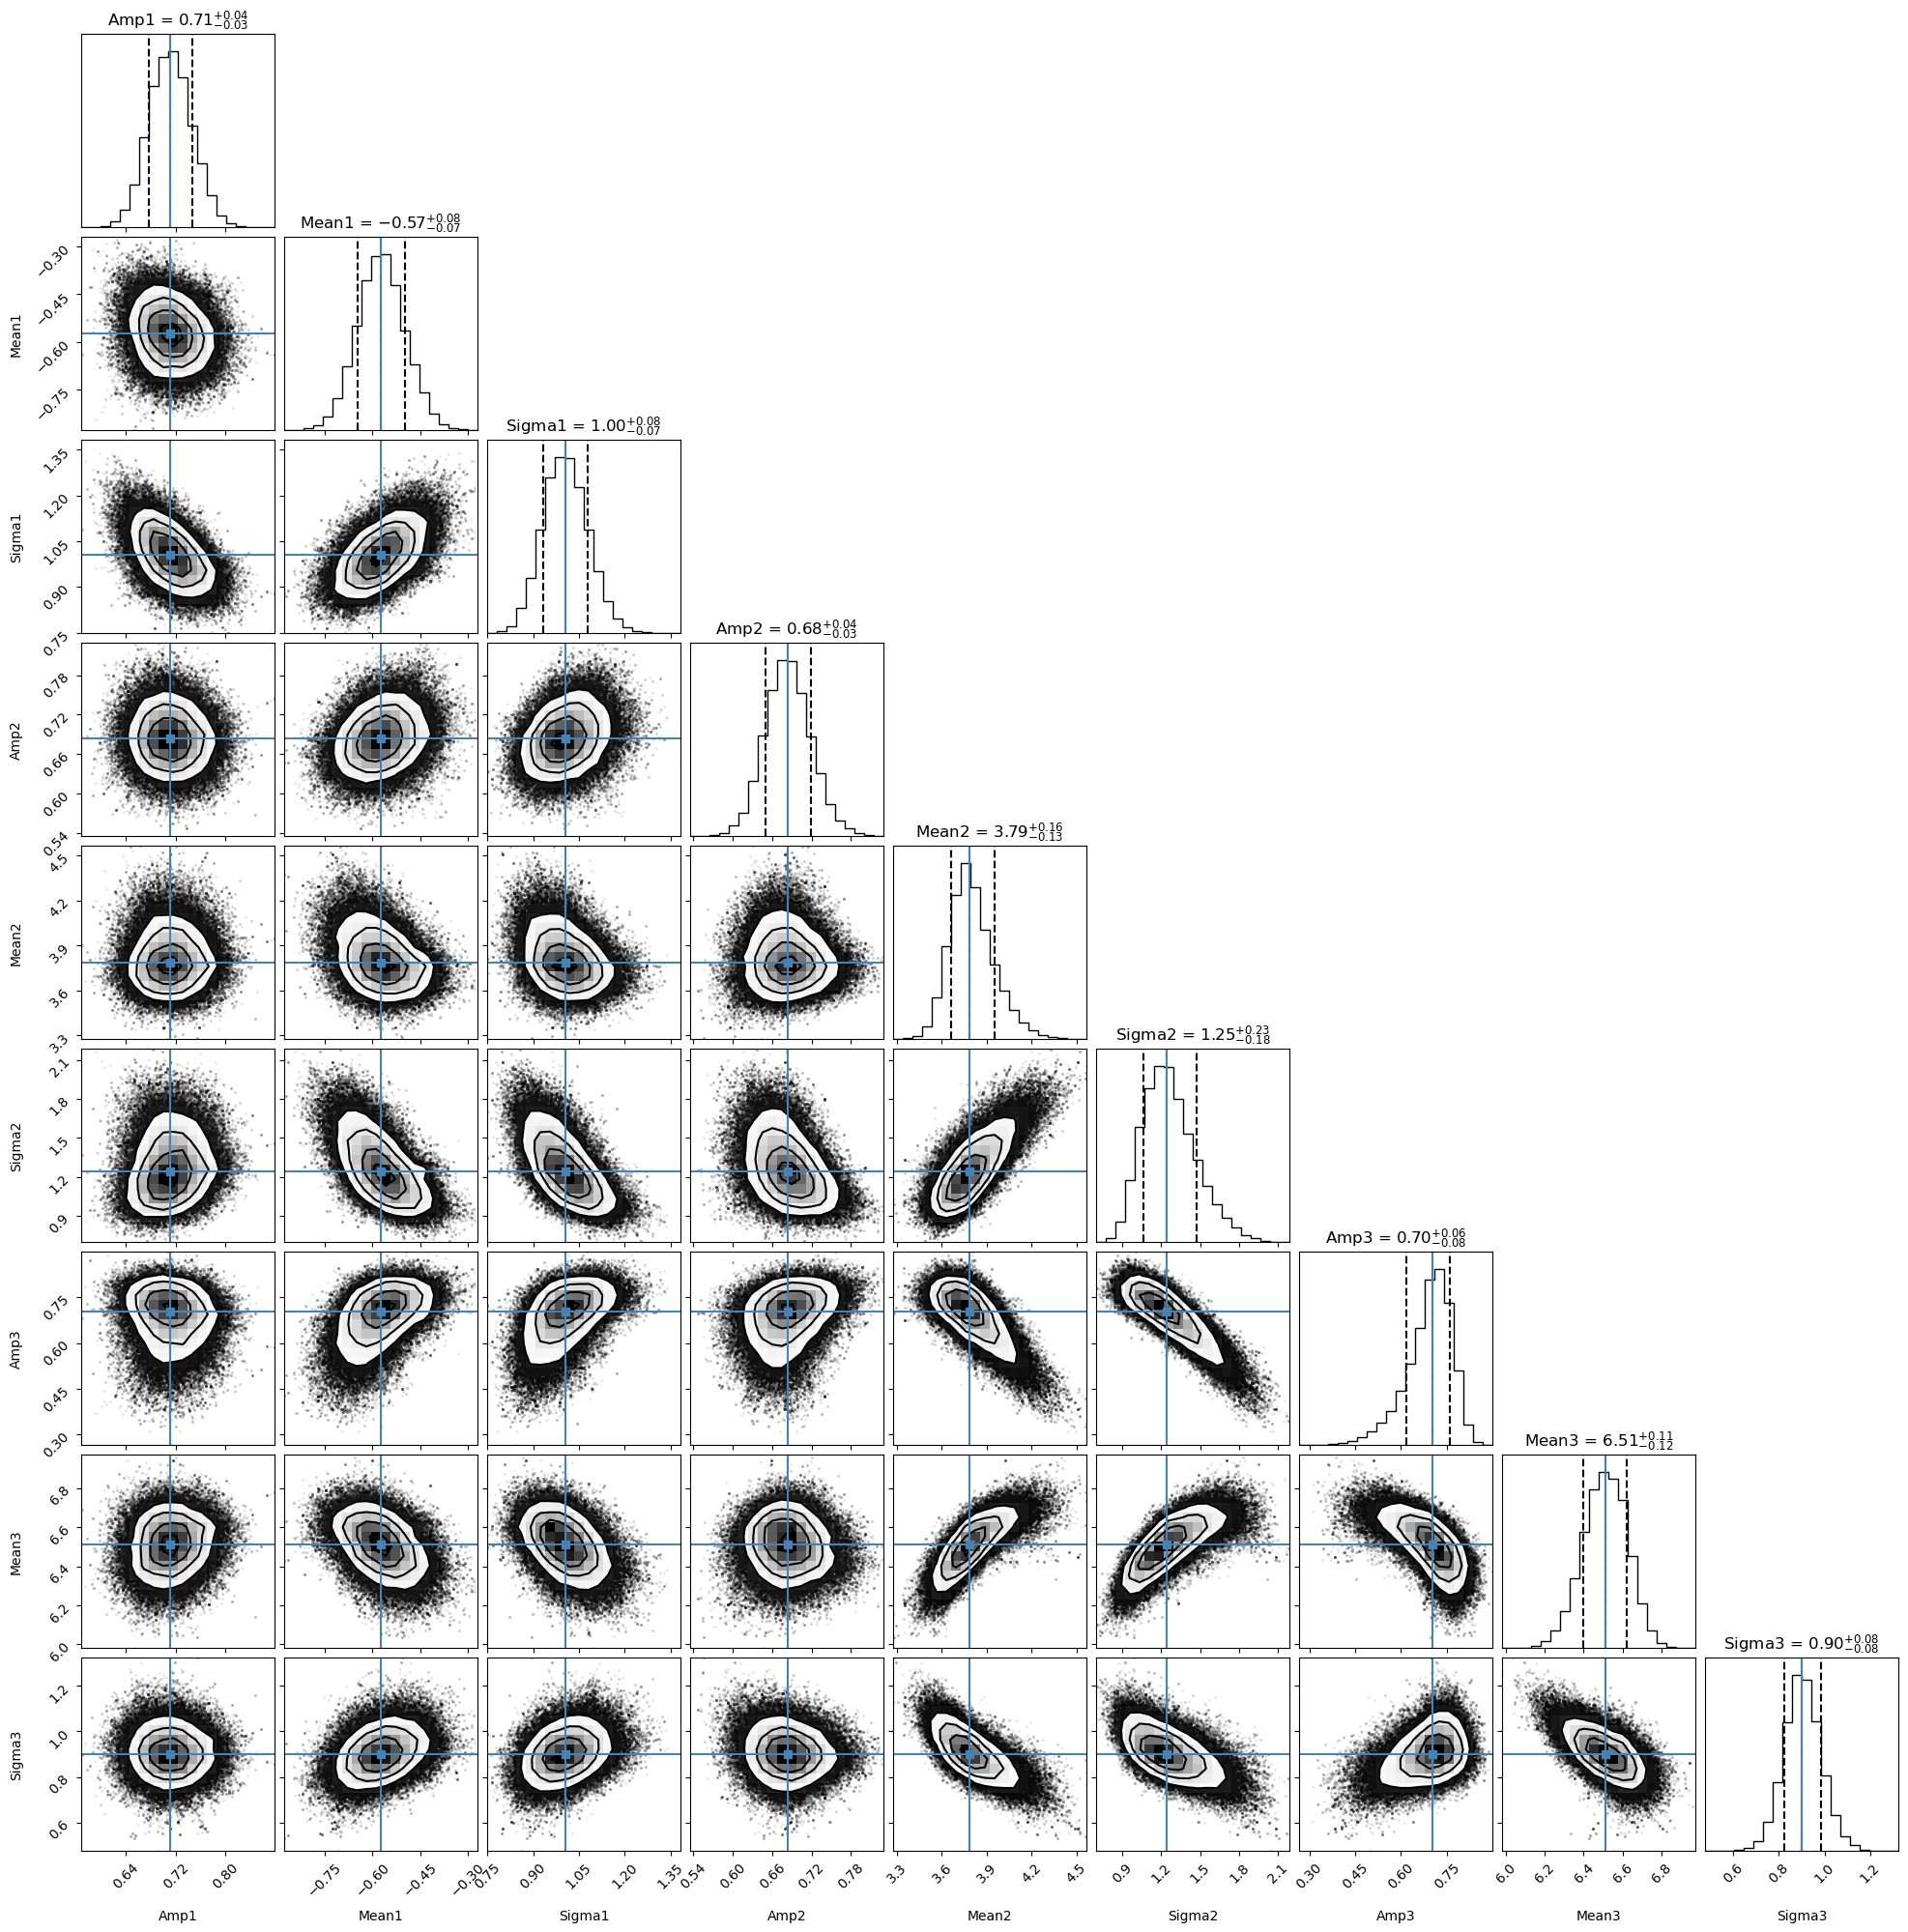

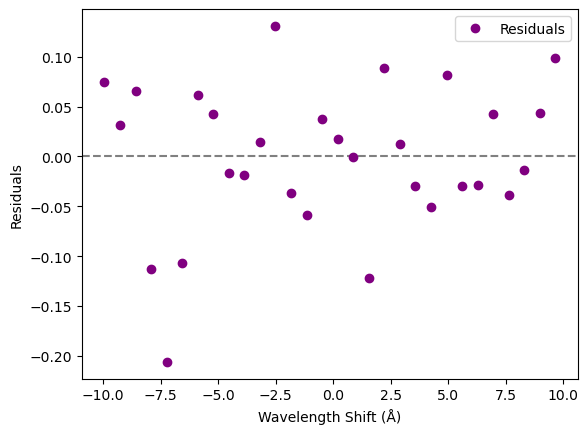

Modified data (normalized to Gaussian 2) saved to C:\Users\Anwender\Desktop\M.A.G.I.C\interim processing data\1modified_data_gaussians_removed2_and_3_wavelength.csv


In [5]:
import numpy as np
import matplotlib.pyplot as plt
import emcee
import pandas as pd
import corner
import os

# =============================================================================
# INPUT PARAMETER OPTIONS======================================================
# =============================================================================

# Data file and filtering parameters
DATA_FILE = "plotted_data_points_grouped_wavelength.csv"
TARGET_REST_WAVELENGTH = 2796.352  # Å - Change this value as needed

# MCMC parameters - more is better, but needs more computational power
NWALKERS = 50
N_STEPS = 5000

# Initial parameter guesses
INITIAL_GUESS = [
    0.77, -0.45, 0.9690,     # Gaussian 1: amplitude, mean, sigma
    0.6836, 3.7869, 1.2805,  # Gaussian 2
    0.6812, 6.6216, 0.9593   # Gaussian 3
]

# Prior exploring ranges
PRIOR_RANGES = {
    'amplitude': (0.0, 1.0),      # Absorption lines: 0 < amp < 1
    'sigma': (0.0, 10.0),         
    'mean_range': None            
}

# Error estimation
FLUX_ERROR = 0.0435  # standart devioten from continuum fit

# Plotting options
PLOT_OPTIONS = {
    'figsize': (10, 6),
    'data_color': 'black',
    'fit_color': 'red',
    'gaussian_colors': ['blue', 'green', 'orange'],
    'residual_color': 'purple'
}

# Output options 
OUTPUT_FILENAME = "1modified_data_gaussians_removed2_and_3_wavelength.csv"

# =============================================================================
# Functions====================================================================
# =============================================================================

# Define the Gaussian function
def gaussian(x, amplitude, mean, sigma):
    return 1 - amplitude * np.exp(-0.5 * ((x - mean) / sigma) ** 2)

# Model with three overlapping Gaussians
def three_gaussians(x, amp1, mean1, sigma1, amp2, mean2, sigma2, amp3, mean3, sigma3):
    return gaussian(x, amp1, mean1, sigma1) + gaussian(x, amp2, mean2, sigma2) + gaussian(x, amp3, mean3, sigma3) - 2

# Log-likelihood function
def log_likelihood(params, x, y, yerr):
    amp1, mean1, sigma1, amp2, mean2, sigma2, amp3, mean3, sigma3 = params
    model = three_gaussians(x, amp1, mean1, sigma1, amp2, mean2, sigma2, amp3, mean3, sigma3)
    return -0.5 * np.sum(((y - model) / yerr) ** 2)

# Prior function
def log_prior(params):
    amp1, mean1, sigma1, amp2, mean2, sigma2, amp3, mean3, sigma3 = params
    
    # Set mean range based on data 
    if PRIOR_RANGES['mean_range'] is None:
        PRIOR_RANGES['mean_range'] = (min(x_data), max(x_data))
    
    min_mean, max_mean = PRIOR_RANGES['mean_range']
    min_amp, max_amp = PRIOR_RANGES['amplitude']
    min_sigma, max_sigma = PRIOR_RANGES['sigma']
    
    # Priors for amplitude
    if not (min_amp < amp1 < max_amp and min_amp < amp2 < max_amp and min_amp < amp3 < max_amp):
        return -np.inf
    # Priors for sigma: must be positive and within reasonable bounds
    if not (min_sigma < sigma1 < max_sigma and min_sigma < sigma2 < max_sigma and min_sigma < sigma3 < max_sigma):
        return -np.inf
    # Priors for mean: must fall within data range
    if not (min_mean < mean1 < max_mean and min_mean < mean2 < max_mean and min_mean < mean3 < max_mean):
        return -np.inf
    return 0

# Define the log-posterior function
def log_posterior(params, x, y, yerr):
    lp = log_prior(params)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(params, x, y, yerr)

# =============================================================================
# Main script==================================================================
# =============================================================================

# Load the data 
script_dir = os.getcwd()
interim_folder = "interim processing data"
data_folder_path = os.path.join(script_dir, interim_folder)

file_path_background = os.path.join(data_folder_path, DATA_FILE)
data = pd.read_csv(file_path_background)

# Filter data for the specific rest-frame wavelength
filtered_data = data[data["Rest Wavelength (Å)"] == TARGET_REST_WAVELENGTH]

# Extract wavelength and flux
x_data = filtered_data["Wavelength Shift (Å)"].values
y_data = filtered_data["Normalized Flux"].values
yerr = np.ones_like(y_data) * FLUX_ERROR

# MCMC
ndim = len(INITIAL_GUESS)
p0 = [INITIAL_GUESS + 1e-4 * np.random.randn(ndim) for _ in range(NWALKERS)]
sampler = emcee.EnsembleSampler(NWALKERS, ndim, log_posterior, args=(x_data, y_data, yerr))
sampler.run_mcmc(p0, N_STEPS, progress=True)
samples = sampler.get_chain(flat=True)
best_fit_params = np.median(samples, axis=0)

# print out the best-fit parameters 
amp1, mean1, sigma1, amp2, mean2, sigma2, amp3, mean3, sigma3 = best_fit_params
print("Best-fit parameters:")
print(f"Amplitude 1: {amp1:.4f}")
print(f"Mean 1: {mean1:.4f} Å")
print(f"Sigma 1: {sigma1:.4f} Å")
print(f"Amplitude 2: {amp2:.4f}")
print(f"Mean 2: {mean2:.4f} Å")
print(f"Sigma 2: {sigma2:.4f} Å")
print(f"Amplitude 3: {amp3:.4f}")
print(f"Mean 3: {mean3:.4f} Å")
print(f"Sigma 3: {sigma3:.4f} Å")

# =============================================================================
# Plot=========================================================================
# =============================================================================
# Plot Gaussians
plt.figure(figsize=PLOT_OPTIONS['figsize'])
plt.plot(x_data, y_data, label="Data", color=PLOT_OPTIONS['data_color'])
plt.plot(x_data, three_gaussians(x_data, *best_fit_params), label="Best Fit (Three Gaussians)", color=PLOT_OPTIONS['fit_color'])

for i, color in enumerate(PLOT_OPTIONS['gaussian_colors']):
    amp, mean, sigma = best_fit_params[i*3:(i+1)*3]
    plt.plot(x_data, gaussian(x_data, amp, mean, sigma), label=f"Gaussian {i+1}", linestyle="--", color=color)

plt.xlabel("Wavelength Shift (Å)")
plt.ylabel("Normalized Flux")
plt.legend()
plt.title(f"Best Fit for Rest Wavelength {TARGET_REST_WAVELENGTH} Å")
plt.show()

# =============================================================================
#  Normalize data to Gaussian 2 (continuum) =======================
# =============================================================================

# Extract just Gaussian 2 (the continuum feature)
gaussian2_continuum = gaussian(x_data, amp2, mean2, sigma2)

# Normalizeing the data by dividing by Gaussian 2 
y_normalized_to_gaussian2 = y_data / gaussian2_continuum

# Plot the normalization process
plt.figure(figsize=PLOT_OPTIONS['figsize'])
plt.plot(x_data, y_data, label="Original Data", color=PLOT_OPTIONS['data_color'])
plt.plot(x_data, y_normalized_to_gaussian2, label="Normalized to Gaussian 2", color="blue")
plt.xlabel("Wavelength Shift (Å)")
plt.ylabel("Normalized Flux")
plt.legend()
plt.title(f"Data Normalized to Gaussian 2 Continuum\n(Rest Wavelength {TARGET_REST_WAVELENGTH} Å)")
plt.show()

# Generate corner plot
fig = corner.corner(
    sampler.get_chain(flat=True),
    labels=["Amp1", "Mean1", "Sigma1", "Amp2", "Mean2", "Sigma2", "Amp3", "Mean3", "Sigma3"],
    truths=best_fit_params,
    quantiles=[0.16, 0.5, 0.84],
    show_titles=True,
    title_kwargs={"fontsize": 12},
    title_fmt=".2f",
)
plt.show()

# Plot residuals
residuals = y_data - three_gaussians(x_data, *best_fit_params)
plt.figure()
plt.axhline(0, color="gray", linestyle="--")
plt.plot(x_data, residuals, "o", color=PLOT_OPTIONS['residual_color'], label="Residuals")
plt.xlabel("Wavelength Shift (Å)")
plt.ylabel("Residuals")
plt.legend()
plt.show()

# =============================================================================
# save results ====================
# =============================================================================

# Save the normalized to Gaussian 2 data 
output_data = pd.DataFrame({
    "Rest Wavelength (Å)": filtered_data["Rest Wavelength (Å)"].values,
    "Wavelength Shift (Å)": x_data,
    "Normalized Flux (After Removing Gaussian 2 and 3)": y_normalized_to_gaussian2  # This is now the normalized data
})

# Save to interim processing folder 
output_file_path = os.path.join(data_folder_path, OUTPUT_FILENAME)
output_data.to_csv(output_file_path, index=False)
print(f"Modified data (normalized to Gaussian 2) saved to {output_file_path}")

# STEP H b third itteration of continuum fitting

100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:11<00:00, 446.30it/s]


Best-fit parameters:
Amplitude 1: 0.7073
Mean 1: -0.6731 Å
Sigma 1: 0.9037 Å
Amplitude 2: 0.6846
Mean 2: -3.3948 Å
Sigma 2: 1.2325 Å
Amplitude 3: 0.7097
Mean 3: -7.7507 Å
Sigma 3: 1.0088 Å


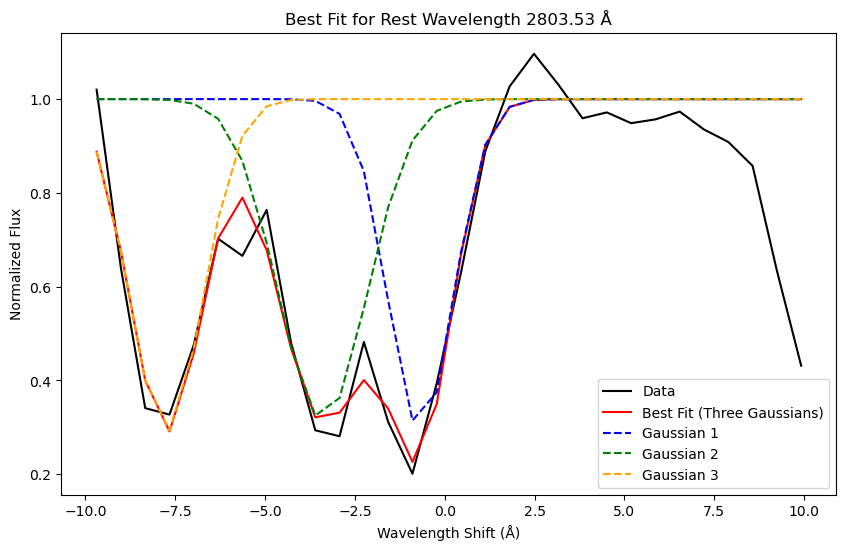

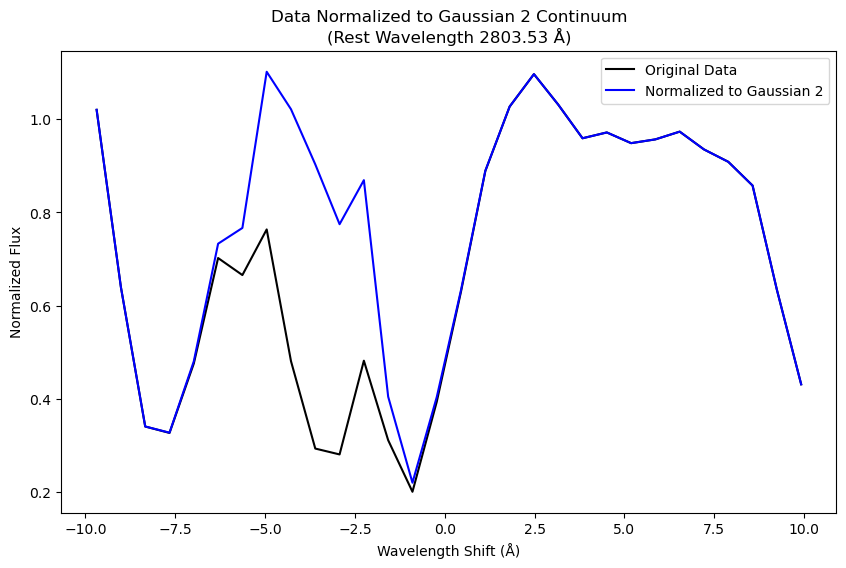

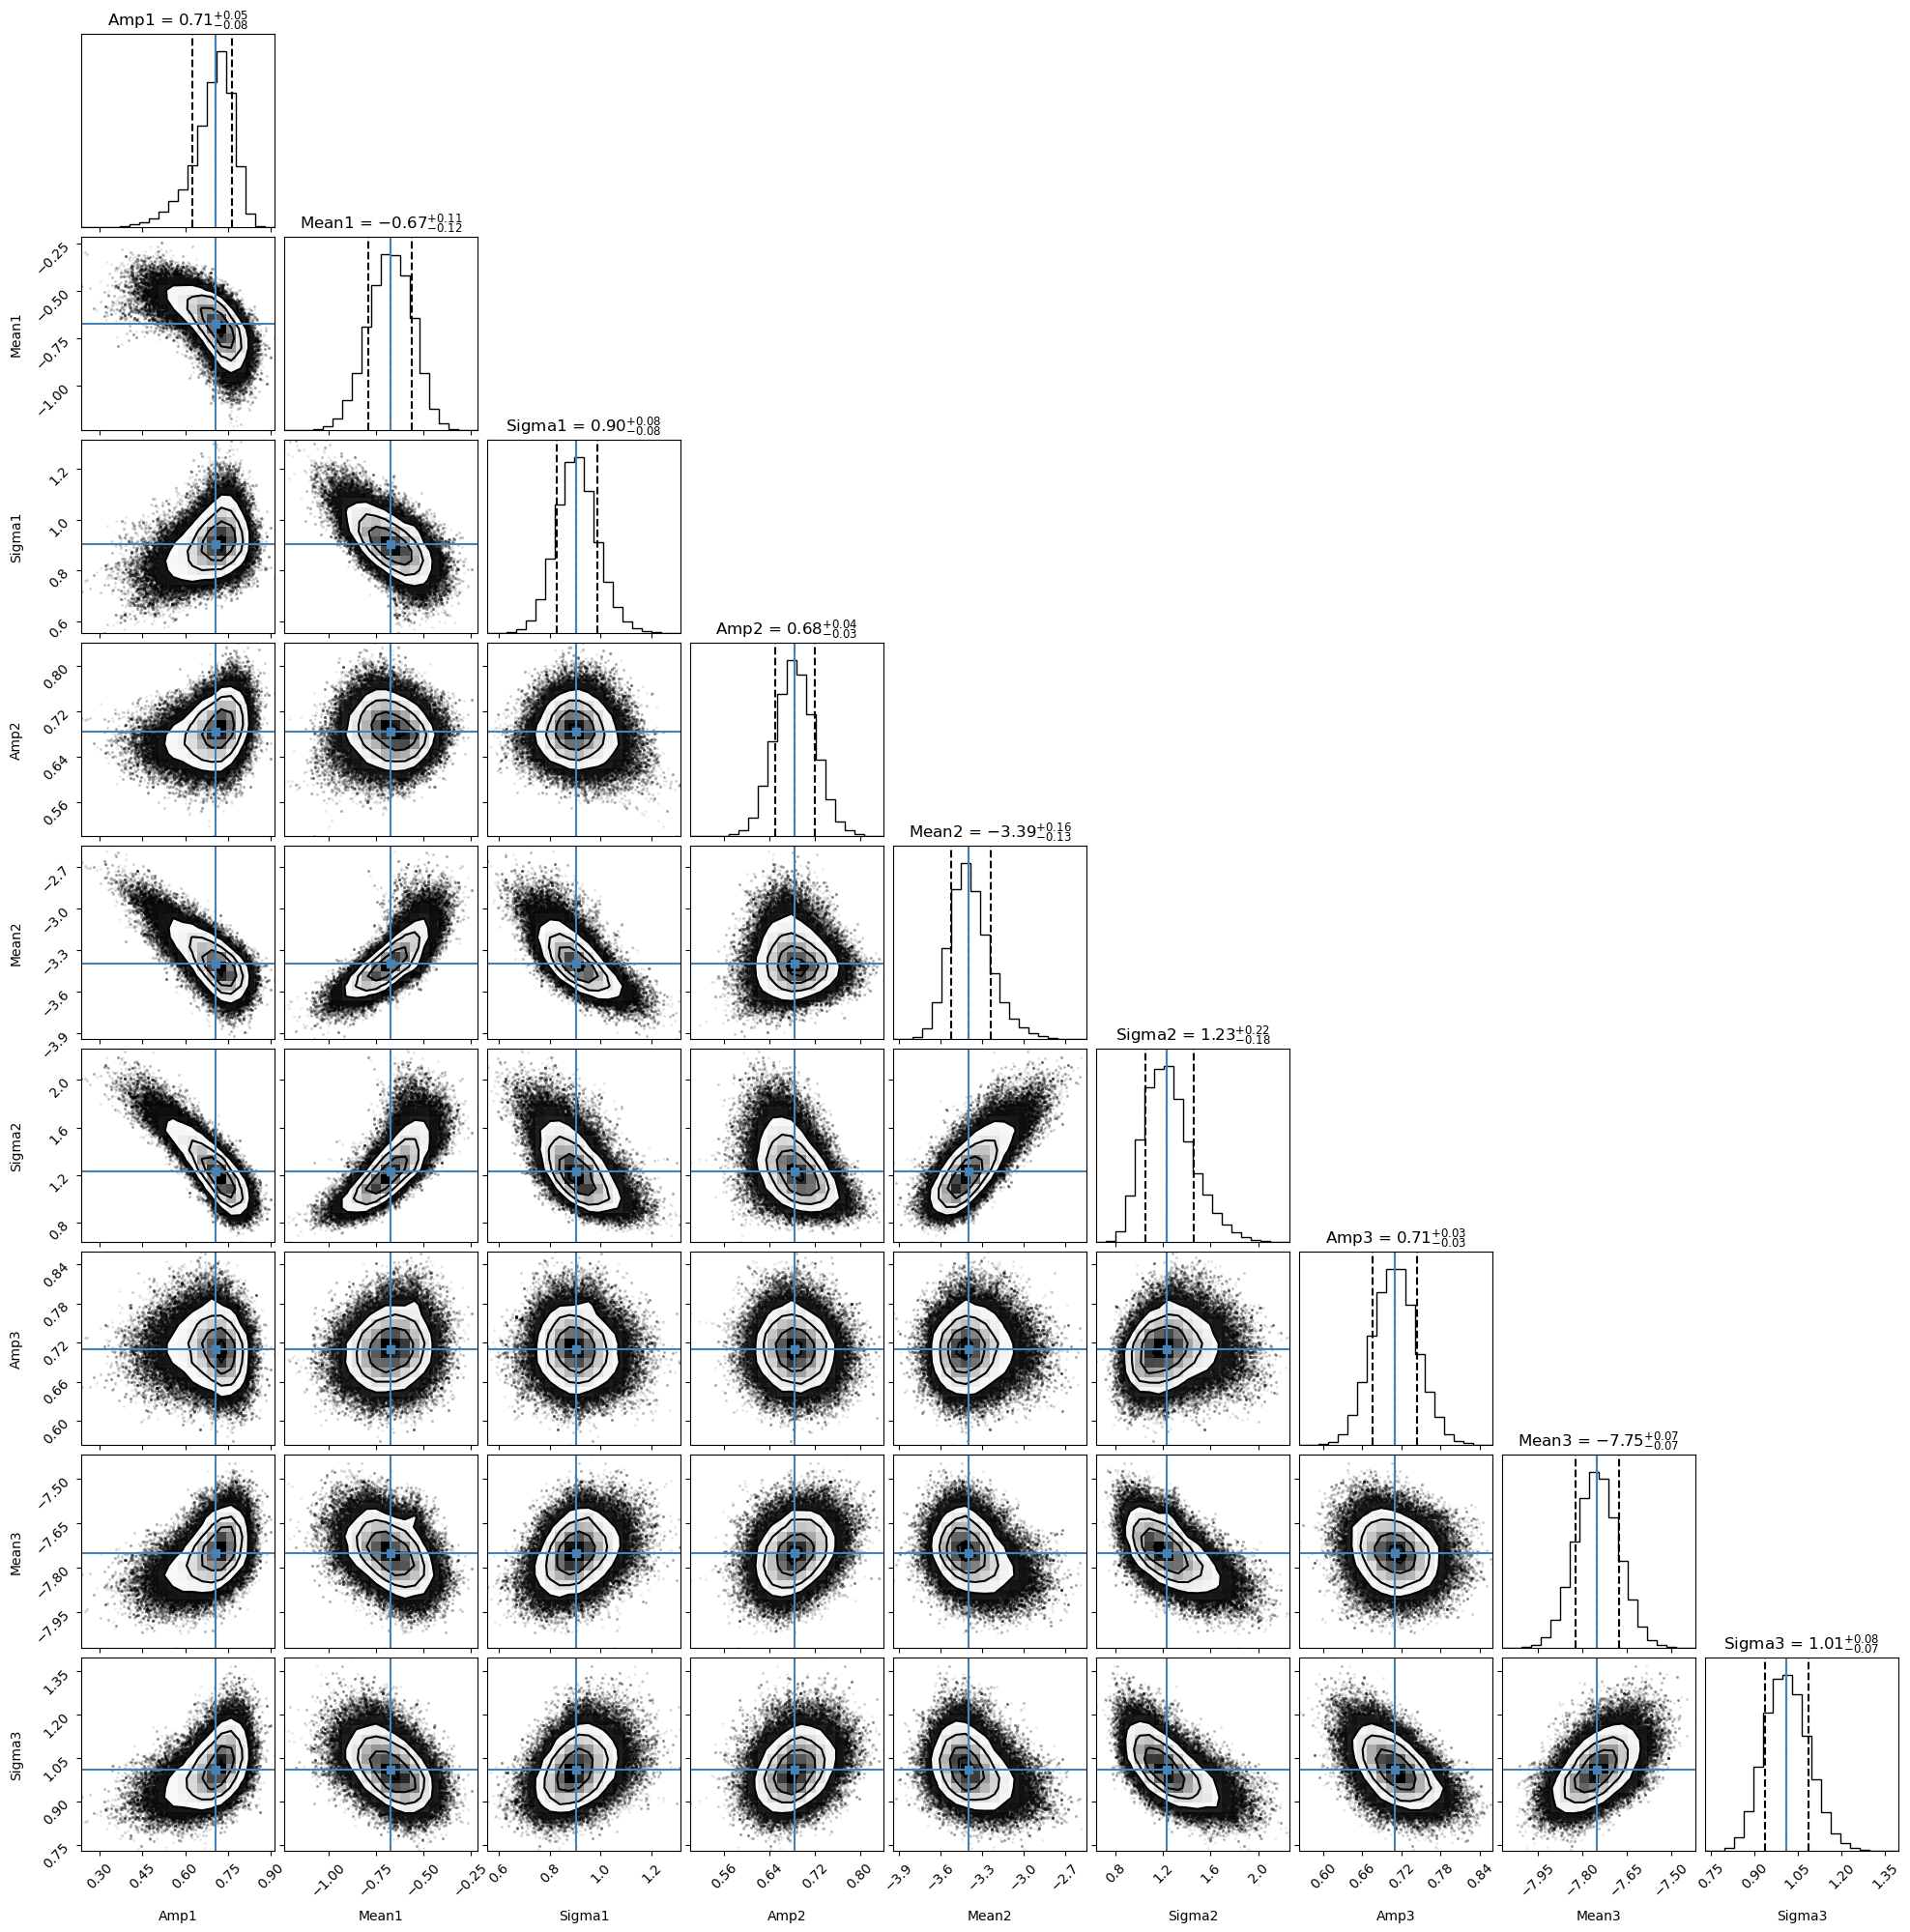

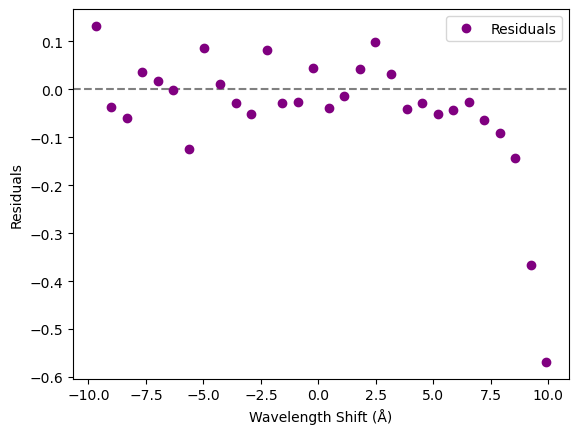

Modified data (normalized to Gaussian 2) saved to C:\Users\Anwender\Desktop\M.A.G.I.C\interim processing data\2modified_data_gaussians_removed2_and_3_wavelength.csv


In [7]:
import numpy as np
import matplotlib.pyplot as plt
import emcee
import pandas as pd
import corner
import os

# =============================================================================
# INPUT PARAMETER OPTIONS======================================================
# =============================================================================

# Data file and filtering parameters
DATA_FILE = "plotted_data_points_grouped_wavelength.csv"
TARGET_REST_WAVELENGTH = 2803.530  # Å - Change this value as needed

# MCMC parameters - more is better, but needs more computational power
NWALKERS = 50
N_STEPS = 5000

# Initial parameter guesses
INITIAL_GUESS = [0.6812, -0.5490, 0.9593,  # Gaussian 1: amplitude, mean, sigma
                 0.6804, -3.392, 1.28,     # Gaussian 2
                 0.7736, -7.627, 0.961]    # Gaussian 3

# Prior exploring ranges
PRIOR_RANGES = {
    'amplitude': (0.0, 1.0),      # Absorption lines: 0 < amp < 1
    'sigma': (0.0, 10.0),         
    'mean_range': None            
}

# Error estimation
FLUX_ERROR = 0.0435  # standart devioten from continuum fit

# Plotting options
PLOT_OPTIONS = {
    'figsize': (10, 6),
    'data_color': 'black',
    'fit_color': 'red',
    'gaussian_colors': ['blue', 'green', 'orange'],
    'residual_color': 'purple'
}

# Output options 
OUTPUT_FILENAME = "2modified_data_gaussians_removed2_and_3_wavelength.csv"

# =============================================================================
# Functions====================================================================
# =============================================================================

# Define the Gaussian function
def gaussian(x, amplitude, mean, sigma):
    return 1 - amplitude * np.exp(-0.5 * ((x - mean) / sigma) ** 2)

#  model with three overlapping Gaussians
def three_gaussians(x, amp1, mean1, sigma1, amp2, mean2, sigma2, amp3, mean3, sigma3):
    return gaussian(x, amp1, mean1, sigma1) + gaussian(x, amp2, mean2, sigma2) + gaussian(x, amp3, mean3, sigma3) - 2

#  log-likelihood function
def log_likelihood(params, x, y, yerr):
    amp1, mean1, sigma1, amp2, mean2, sigma2, amp3, mean3, sigma3 = params
    model = three_gaussians(x, amp1, mean1, sigma1, amp2, mean2, sigma2, amp3, mean3, sigma3)
    return -0.5 * np.sum(((y - model) / yerr) ** 2)

#  prior function
def log_prior(params):
    amp1, mean1, sigma1, amp2, mean2, sigma2, amp3, mean3, sigma3 = params
    
    # Set mean range
    if PRIOR_RANGES['mean_range'] is None:
        PRIOR_RANGES['mean_range'] = (min(x_data), max(x_data))
    
    min_mean, max_mean = PRIOR_RANGES['mean_range']
    min_amp, max_amp = PRIOR_RANGES['amplitude']
    min_sigma, max_sigma = PRIOR_RANGES['sigma']
    
    # Priors for amplitude
    if not (min_amp < amp1 < max_amp and min_amp < amp2 < max_amp and min_amp < amp3 < max_amp):
        return -np.inf
    # Priors for sigma: must be positive and within reasonable bounds
    if not (min_sigma < sigma1 < max_sigma and min_sigma < sigma2 < max_sigma and min_sigma < sigma3 < max_sigma):
        return -np.inf
    # Priors for mean: must fall within data range
    if not (min_mean < mean1 < max_mean and min_mean < mean2 < max_mean and min_mean < mean3 < max_mean):
        return -np.inf
    return 0

# Define the log-posterior function
def log_posterior(params, x, y, yerr):
    lp = log_prior(params)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(params, x, y, yerr)

# =============================================================================
# Main script==================================================================
# =============================================================================

# Load the data 
script_dir = os.getcwd()
interim_folder = "interim processing data"
data_folder_path = os.path.join(script_dir, interim_folder)

file_path_background = os.path.join(data_folder_path, DATA_FILE)
data = pd.read_csv(file_path_background)

# Filter data for the specific rest-frame wavelength
filtered_data = data[data["Rest Wavelength (Å)"] == TARGET_REST_WAVELENGTH]

# Extract wavelength and flux
x_data = filtered_data["Wavelength Shift (Å)"].values
y_data = filtered_data["Normalized Flux"].values
yerr = np.ones_like(y_data) * FLUX_ERROR

# MCMC
ndim = len(INITIAL_GUESS)
p0 = [INITIAL_GUESS + 1e-4 * np.random.randn(ndim) for _ in range(NWALKERS)]
sampler = emcee.EnsembleSampler(NWALKERS, ndim, log_posterior, args=(x_data, y_data, yerr))
sampler.run_mcmc(p0, N_STEPS, progress=True)
samples = sampler.get_chain(flat=True)
best_fit_params = np.median(samples, axis=0)



# print out the best-fit parameters (those can be set in for an aditional follow up iteration)
amp1, mean1, sigma1, amp2, mean2, sigma2, amp3, mean3, sigma3 = best_fit_params
print("Best-fit parameters:")
print(f"Amplitude 1: {amp1:.4f}")
print(f"Mean 1: {mean1:.4f} Å")
print(f"Sigma 1: {sigma1:.4f} Å")
print(f"Amplitude 2: {amp2:.4f}")
print(f"Mean 2: {mean2:.4f} Å")
print(f"Sigma 2: {sigma2:.4f} Å")
print(f"Amplitude 3: {amp3:.4f}")
print(f"Mean 3: {mean3:.4f} Å")
print(f"Sigma 3: {sigma3:.4f} Å")


# =============================================================================
# Plot=========================================================================
# =============================================================================
# Plot individual Gaussians
plt.figure(figsize=PLOT_OPTIONS['figsize'])
plt.plot(x_data, y_data, label="Data", color=PLOT_OPTIONS['data_color'])
plt.plot(x_data, three_gaussians(x_data, *best_fit_params), label="Best Fit (Three Gaussians)", color=PLOT_OPTIONS['fit_color'])

for i, color in enumerate(PLOT_OPTIONS['gaussian_colors']):
    amp, mean, sigma = best_fit_params[i*3:(i+1)*3]
    plt.plot(x_data, gaussian(x_data, amp, mean, sigma), label=f"Gaussian {i+1}", linestyle="--", color=color)

plt.xlabel("Wavelength Shift (Å)")
plt.ylabel("Normalized Flux")
plt.legend()
plt.title(f"Best Fit for Rest Wavelength {TARGET_REST_WAVELENGTH} Å")
plt.show()


# =============================================================================
# Normalize data to Gaussian 2 (continuum) =======================
# =============================================================================

# Extract Gaussian 2 (the continuum feature)
gaussian2_continuum = gaussian(x_data, amp2, mean2, sigma2)

# Normalize the data by dividing by Gaussian 2 
y_normalized_to_gaussian2 = y_data / gaussian2_continuum

# Plot 
plt.figure(figsize=PLOT_OPTIONS['figsize'])
plt.plot(x_data, y_data, label="Original Data", color=PLOT_OPTIONS['data_color'])
plt.plot(x_data, y_normalized_to_gaussian2, label="Normalized to Gaussian 2", color="blue")
plt.xlabel("Wavelength Shift (Å)")
plt.ylabel("Normalized Flux")
plt.legend()
plt.title(f"Data Normalized to Gaussian 2 Continuum\n(Rest Wavelength {TARGET_REST_WAVELENGTH} Å)")
plt.show()


# Generate corner plot
fig = corner.corner(
    sampler.get_chain(flat=True),
    labels=["Amp1", "Mean1", "Sigma1", "Amp2", "Mean2", "Sigma2", "Amp3", "Mean3", "Sigma3"],
    truths=best_fit_params,
    quantiles=[0.16, 0.5, 0.84],
    show_titles=True,
    title_kwargs={"fontsize": 12},
    title_fmt=".2f",
)
plt.show()

# Plot residuals
residuals = y_data - three_gaussians(x_data, *best_fit_params)
plt.figure()
plt.axhline(0, color="gray", linestyle="--")
plt.plot(x_data, residuals, "o", color=PLOT_OPTIONS['residual_color'], label="Residuals")
plt.xlabel("Wavelength Shift (Å)")
plt.ylabel("Residuals")
plt.legend()
plt.show()

# =============================================================================
# save results=================================================================
# =============================================================================

# Save the normalized to Gaussian 2 data
output_data = pd.DataFrame({
    "Rest Wavelength (Å)": filtered_data["Rest Wavelength (Å)"].values,
    "Wavelength Shift (Å)": x_data,
    "Normalized Flux (After Removing Gaussian 2 and 3)": y_normalized_to_gaussian2 
})

# Save to interim processing folder 
output_file_path = os.path.join(data_folder_path, OUTPUT_FILENAME)
output_data.to_csv(output_file_path, index=False)
print(f"Modified data (normalized to Gaussian 2) saved to {output_file_path}")

# Combining STEP G, STEP Ha and STEP Hb

Final combined data saved to: C:\Users\Anwender\Desktop\M.A.G.I.C\interim processing data\final_combined_corrected_data.csv


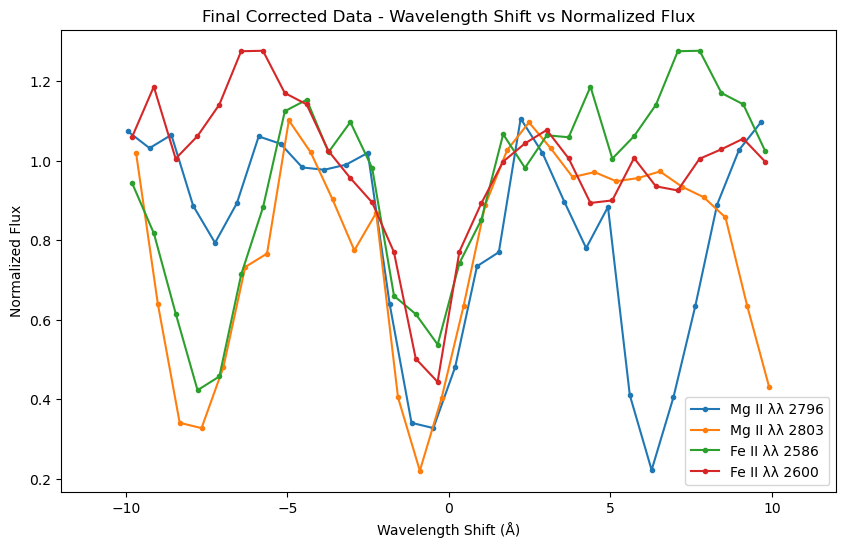

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import os

# =============================================================================
# Loading csv files
# =============================================================================
script_dir = os.getcwd()
interim_folder = "interim processing data"
data_folder_path = os.path.join(script_dir, interim_folder)
original_file = os.path.join(data_folder_path, "plotted_data_points_grouped_wavelength.csv")
modified_file_1 = os.path.join(data_folder_path, "1modified_data_gaussians_removed2_and_3_wavelength.csv")
modified_file_2 = os.path.join(data_folder_path, "2modified_data_gaussians_removed2_and_3_wavelength.csv")
output_file = os.path.join(data_folder_path, "final_combined_corrected_data.csv")
original_data = pd.read_csv(original_file)
modified_data_1 = pd.read_csv(modified_file_1)
modified_data_2 = pd.read_csv(modified_file_2)
final_data = original_data.copy()

# =============================================================================
# Replace the flux values for 2796.352 Å with the corrected values from modified_file_1
# =============================================================================

wavelength_1 = 2796.352
mask_1 = final_data["Rest Wavelength (Å)"] == wavelength_1

if mask_1.sum() > 0:
    corrected_1 = modified_data_1[["Wavelength Shift (Å)", "Normalized Flux (After Removing Gaussian 2 and 3)"]].copy()
    corrected_1.columns = ["Wavelength Shift (Å)", "Normalized Flux"]
    
    for idx in final_data[mask_1].index:
        shift_val = final_data.loc[idx, "Wavelength Shift (Å)"]
        corrected_row = corrected_1[corrected_1["Wavelength Shift (Å)"] == shift_val]
        if not corrected_row.empty:
            final_data.loc[idx, "Normalized Flux"] = corrected_row["Normalized Flux"].values[0]

# =============================================================================
# Replace the flux values for 2803.53 Å with the corrected values from modified_file_2
# =============================================================================            
            
wavelength_2 = 2803.53
mask_2 = final_data["Rest Wavelength (Å)"] == wavelength_2

if mask_2.sum() > 0:
    corrected_2 = modified_data_2[["Wavelength Shift (Å)", "Normalized Flux (After Removing Gaussian 2 and 3)"]].copy()
    corrected_2.columns = ["Wavelength Shift (Å)", "Normalized Flux"]
    
    for idx in final_data[mask_2].index:
        shift_val = final_data.loc[idx, "Wavelength Shift (Å)"]
        corrected_row = corrected_2[corrected_2["Wavelength Shift (Å)"] == shift_val]
        if not corrected_row.empty:
            final_data.loc[idx, "Normalized Flux"] = corrected_row["Normalized Flux"].values[0]

# =============================================================================
# save combined file===========================================================
# =============================================================================

final_data.to_csv(output_file, index=False)
print(f"Final combined data saved to: {output_file}")

# =============================================================================
# Plot=========================================================================
# =============================================================================

line_labels = {
    2796.352: 'Mg II λλ 2796',
    2803.530: 'Mg II λλ 2803',
    2586.649: 'Fe II λλ 2586',
    2600.172: 'Fe II λλ 2600'
}
plt.figure(figsize=(10, 6))
for rest_wavelength in final_data['Rest Wavelength (Å)'].unique():
    subset = final_data[final_data['Rest Wavelength (Å)'] == rest_wavelength]
    label = line_labels.get(rest_wavelength, f'{rest_wavelength} Å')
    plt.plot(subset['Wavelength Shift (Å)'], subset['Normalized Flux'], label=label, marker='o', markersize=3)
plt.xlabel('Wavelength Shift (Å)')
plt.ylabel('Normalized Flux')
plt.title('Final Corrected Data - Wavelength Shift vs Normalized Flux')
plt.xlim(-12, 12)
plt.legend()
plt.show()

# STEP I Measure EW

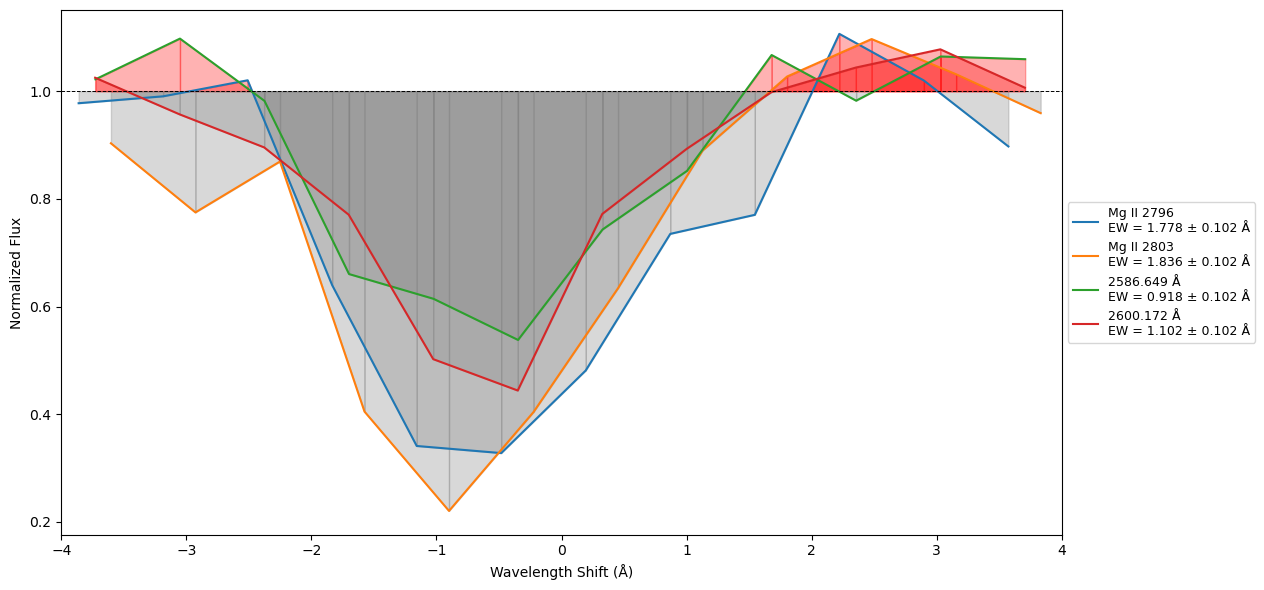

Equivalent widths saved to C:\Users\Anwender\Desktop\M.A.G.I.C\interim processing data\equivalent_widths_with_uncertainties.csv


In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# =============================================================================
# Adjustable Parameters
# =============================================================================
# File paths
SCRIPT_DIR = os.getcwd()
INTERIM_FOLDER = "interim processing data"
DATA_FOLDER_PATH = os.path.join(SCRIPT_DIR, INTERIM_FOLDER)
DATA_FILE = os.path.join(DATA_FOLDER_PATH, "final_combined_corrected_data.csv")

# Spectral line labels in the csv file 
LINE_LABELS = {
    2796.352: 'Mg II 2796',
    2803.530: 'Mg II 2803',
    2586.65: 'Fe II 2587',
    2600.17: 'Fe II 2600'
}

# Analysis parameters
CONTINUUM_STD = 0.0435  # Continuum noise level from SK_cont_fit
WAVELENGTH_WINDOW = (-4,4)  # Window around each line center in Å texclude absorbtion features nearby 

# Plot parameters
PLOT_FIGSIZE = (15, 6)
PLOT_XLIMITS = (-4, 4)
PLOT_LEGEND_FONTSIZE = 9
PLOT_LEGEND_POSITION = (1, 0.5) 

# Output file
OUTPUT_CSV = "equivalent_widths_with_uncertainties.csv"

# =============================================================================
# Function Definitions
# =============================================================================

def calculate_equivalent_width(wavelength_shift, normalized_flux, noise_level):
    """Calculate equivalent width/ uncertainty."""
    sort_idx = np.argsort(wavelength_shift)
    wavelength_shift = wavelength_shift[sort_idx]
    normalized_flux = normalized_flux[sort_idx]

    net_flux = 1 - normalized_flux
    ew = np.trapz(net_flux, wavelength_shift)

    diffs = np.diff(wavelength_shift)
    delta_lambda_avg = np.mean(np.abs(diffs)) if len(diffs) > 0 else 0
    N = len(wavelength_shift)
    ew_uncertainty = noise_level * delta_lambda_avg * np.sqrt(N)

    return ew, ew_uncertainty

# =============================================================================
# Main Processing and Plot
# =============================================================================


data = pd.read_csv(DATA_FILE)
equivalent_widths = {}
plt.figure(figsize=PLOT_FIGSIZE)

for rest_wavelength in data['Rest Wavelength (Å)'].unique():
    subset = data[data['Rest Wavelength (Å)'] == rest_wavelength]
    subset = subset[
        (subset['Wavelength Shift (Å)'] >= WAVELENGTH_WINDOW[0]) & 
        (subset['Wavelength Shift (Å)'] <= WAVELENGTH_WINDOW[1])
    ]

    wavelength_shift = subset['Wavelength Shift (Å)'].values
    normalized_flux = subset['Normalized Flux'].values

    # Calculate equivalent width
    ew, ew_err = calculate_equivalent_width(wavelength_shift, normalized_flux, CONTINUUM_STD)
    equivalent_widths[rest_wavelength] = (ew, ew_err)
    
    # Plot
    
    base_label = LINE_LABELS.get(rest_wavelength, f'{rest_wavelength} Å')
    label_with_ew = f"{base_label}\nEW = {ew:.3f} ± {ew_err:.3f} Å"
    plt.plot(wavelength_shift, normalized_flux, label=label_with_ew)

    for i in range(len(wavelength_shift) - 1):
        x1, x2 = wavelength_shift[i], wavelength_shift[i+1]
        y1, y2 = normalized_flux[i], normalized_flux[i+1]

        if y1 < 1 and y2 < 1:
            plt.fill_between([x1, x2], [y1, y2], 1, color='gray', alpha=0.3)
        elif y1 > 1 and y2 > 1:
            plt.fill_between([x1, x2], [y1, y2], 1, color='red', alpha=0.3)
        elif (y1 < 1 and y2 > 1) or (y1 > 1 and y2 < 1):
            x_cross = x1 + (x2 - x1) * (1 - y1) / (y2 - y1)
            plt.fill_between([x1, x_cross], [y1, 1], 1, color='gray' if y1 < 1 else 'red', alpha=0.3)
            plt.fill_between([x_cross, x2], [1, y2], 1, color='gray' if y2 < 1 else 'red', alpha=0.3)

plt.xlabel('Wavelength Shift (Å)')
plt.ylabel('Normalized Flux')
plt.xlim(PLOT_XLIMITS)
plt.axhline(1, color='black', ls='--', lw=0.7)
plt.legend(loc='center left', bbox_to_anchor=PLOT_LEGEND_POSITION, fontsize=PLOT_LEGEND_FONTSIZE)
plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.show()

# =============================================================================
# Save EW mesurements and uncertainties
# =============================================================================
output_file_path = os.path.join(DATA_FOLDER_PATH, OUTPUT_CSV)
results_df = pd.DataFrame([
    {
        "Rest Wavelength (Å)": rest_wavelength,
        "Line": LINE_LABELS.get(rest_wavelength, str(rest_wavelength)),
        "EW (Å)": ew,
        "Uncertainty (Å)": ew_err
    }
    for rest_wavelength, (ew, ew_err) in equivalent_widths.items()
])
results_df.to_csv(output_file_path, index=False)
print(f"Equivalent widths saved to {output_file_path}")

# STEP J Generate Synthetic CoG and STEP K Fit CoG Parameters

100%|██████████████████████████████████████████████████████████████████████████████| 7000/7000 [29:15<00:00,  3.99it/s]


logN_Mg = 16.69 (+0.29/-0.45)
logN_Fe = 15.28 (+0.49/-0.34)
b_nontherm = 21.09 (+2.85/-2.81) [km s⁻¹]

Line		Measured EW	Model EW	Ratio		Measured Error
Mg II 2796.352 	1.7800	1.8484	0.96		0.1020
Mg II 2803.530 	1.8200	1.7010	1.07		0.1020
Fe II 2600.1720	1.1020	1.1142	0.99		0.1020
Fe II 2586.6493	0.9180	0.9446	0.97		0.1020


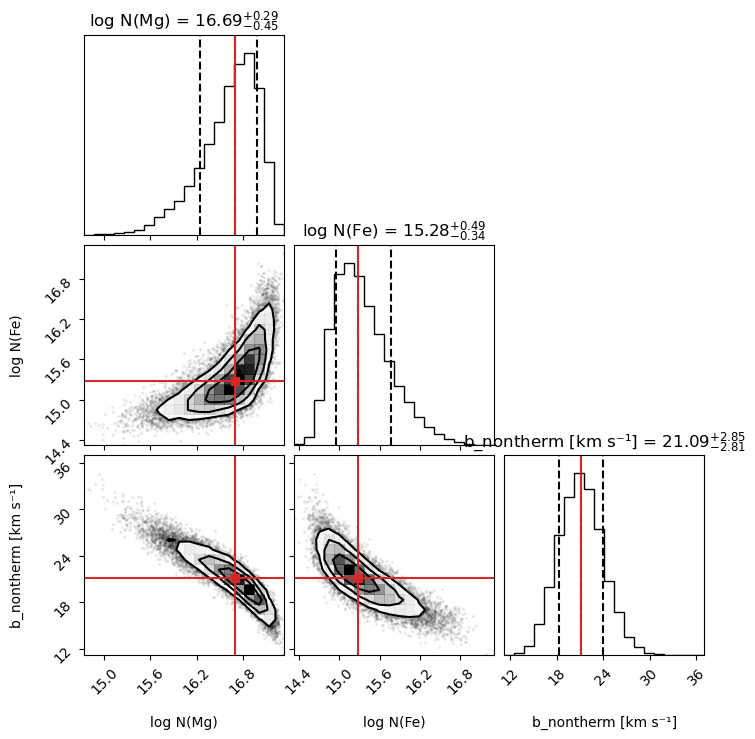

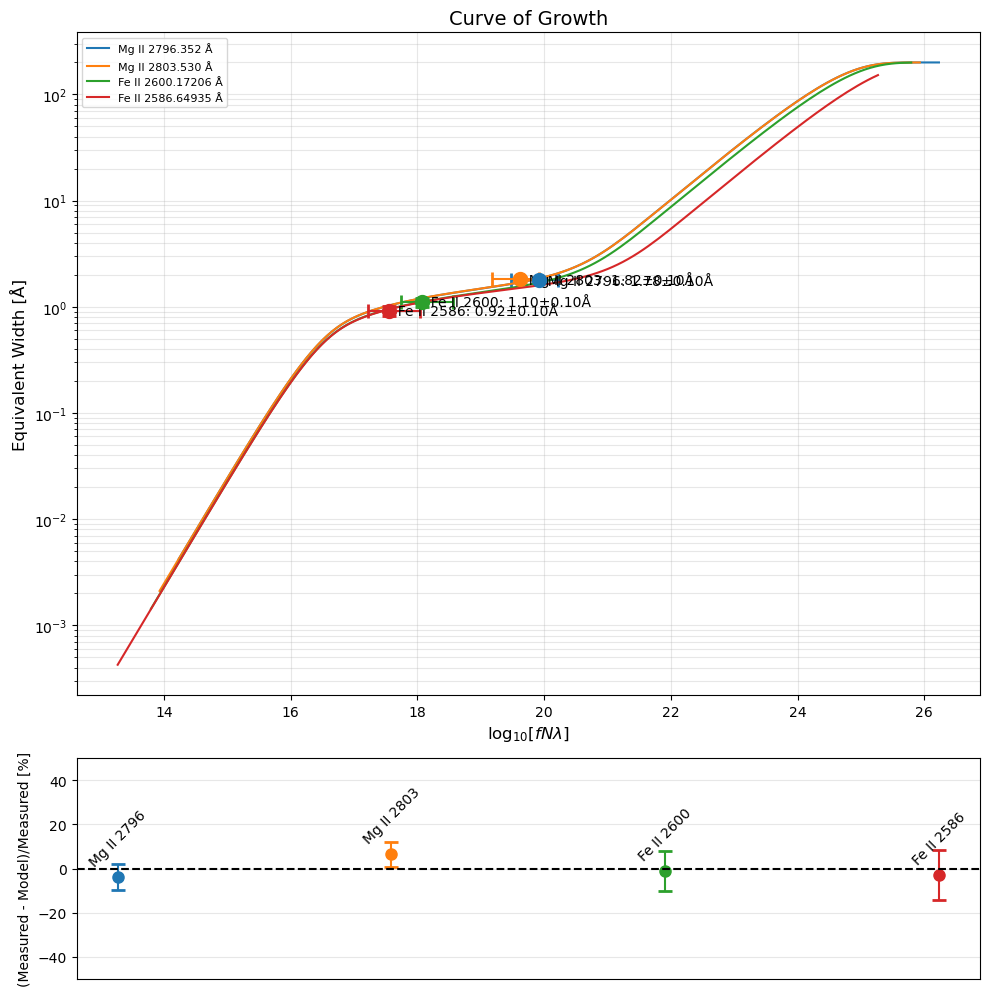

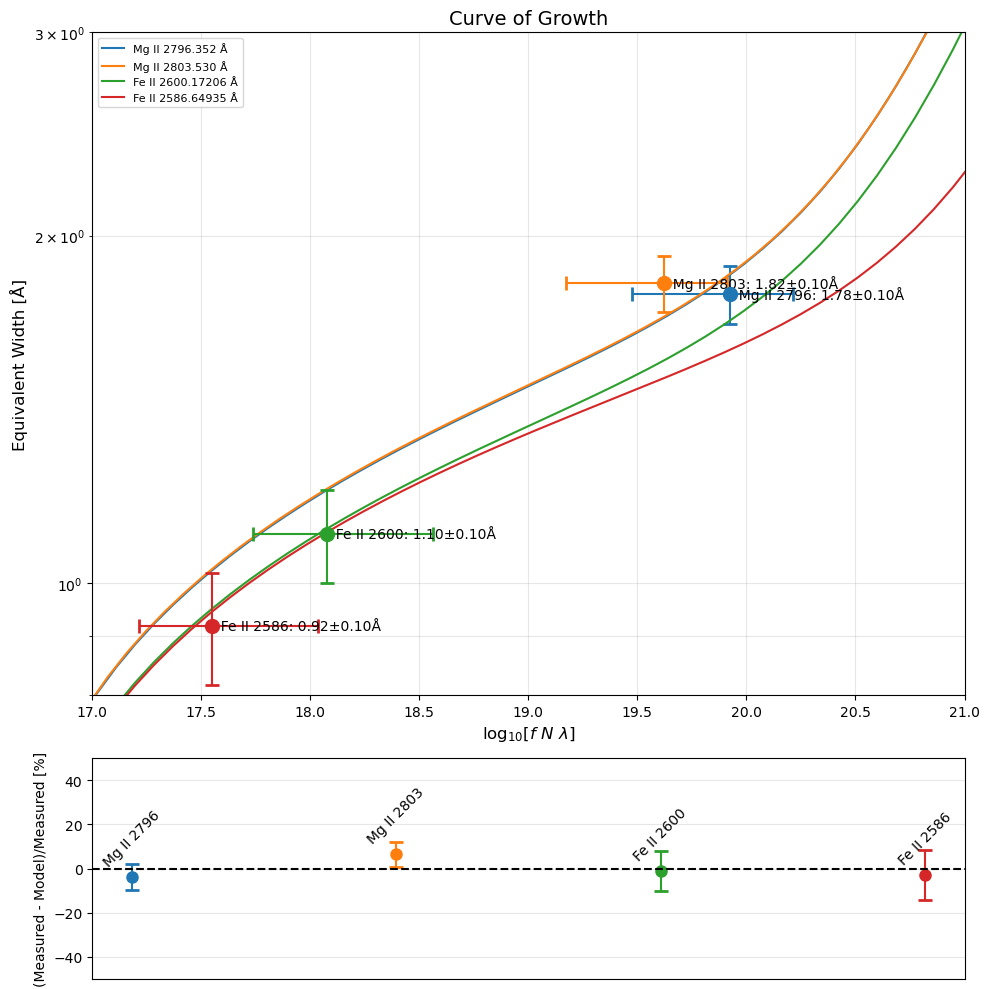

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import emcee
import corner
from scipy.special import voigt_profile
from astropy.constants import c, k_B, m_e, e
import astropy.units as u
from matplotlib.patches import Patch
import matplotlib.cm as cm

# =============================================================================
# ADJUSTABLE PARAMETERS
# =============================================================================

# MCMC parameters
N_WALKERS = 40       # nwalkers and nsteps increase acurassy at the cost of more processing power with these parameters it may take an hour
N_STEPS = 7000
BURN_IN = 500       # excludes the first random walkers
THINNING = 15       #reduce the density of data points when plotting

# Prior ranges
LOG_N_MG_RANGE = (13, 20)  # walking range for logN(Mg)
LOG_N_FE_RANGE = (13, 20)  # walking range for logN(Fe)  
B_TURB_RANGE = (1, 100)    # min, max for b_turb/nonthermal in km/s

# Initial guess for MCMC
INITIAL_GUESS = [16.5, 15.6, 21]  # second iteration can adjust parameters

# Physical parameters
TEMPERATURE = 10000 * u.K  # Gas temperature (typical for MgII and Fe II)
RADIAL_VELOCITY = 0 * u.km/u.s  # Systemic radial velocity
SPECTRAL_RESOLUTION = 100000  # Simulated Coigt Profile Instrument resolution R = λ/Δλ

# Plotting ranges for CoG plots
COG_XLIM = [17, 21]  
COG_YLIM = [0.8, 3]   

# =============================================================================
# FIXED DATA AND FUNCTIONS (DO NOT MODIFY BELOW UNLESS NECESSARY)
# =============================================================================

# Line list
lines = [
    {'label': 'Mg II 2796.352 Å', 'wavelength': 2796.352, 'fik': 6.08e-01, 'Aki': 2.60e+08, 'wavelength_lims': [2696.352, 2896.352]},
    {'label': 'Mg II 2803.530 Å', 'wavelength': 2803.530, 'fik': 3.03e-01, 'Aki': 2.57e+08, 'wavelength_lims': [2703.530, 2903.530]},
    {'label': 'Fe II 2600.17206 Å', 'wavelength': 2600.17206, 'fik': 2.39e-01, 'Aki': 2.35e+08, 'wavelength_lims': [2500.17206, 2700.17206]},
    {'label': 'Fe II 2586.64935 Å', 'wavelength': 2586.64935, 'fik': 7.17e-02, 'Aki': 8.94e+07, 'wavelength_lims': [2486.64935, 2686.64935]},
    #{'label': 'Fe II 2382.76390 Å', 'wavelength': 2382.76390, 'fik': 3.20e-01, 'Aki': 3.13e+08, 'wavelength_lims': [2282.76390, 2482.76390]},
    #{'label': 'Fe II 2344.21273 Å', 'wavelength': 2344.21273, 'fik': 1.14e-01, 'Aki': 1.73e+08, 'wavelength_lims': [2244.21273, 2444.21273]},
]

measured_ews = {
    'Mg II 2796.352 Å': 1.780,
    'Mg II 2803.530 Å': 1.820,
    'Fe II 2586.64935 Å': 0.918,
    'Fe II 2600.17206 Å': 1.102,
    #'Fe II 2382.76390 Å': ,
    #'Fe II 2344.21273 Å': ,
}

# Added EW uncertainties
measured_ew_errors = {
    'Mg II 2796.352 Å': 0.102,
    'Mg II 2803.530 Å': 0.102,
    'Fe II 2586.64935 Å': 0.102,
    'Fe II 2600.17206 Å': 0.102,
    #'Fe II 2382.76390 Å': ,
    #'Fe II 2344.21273 Å': ,
}

element_masses = {'Mg': 24.305, 'Fe': 55.845}

# =============================================================================
# Functions
# =============================================================================

def get_ion_mass(label):
    if "Mg" in label:
        return element_masses['Mg'] * u.u
    elif "Fe" in label:
        return element_masses['Fe'] * u.u
    raise ValueError(f"Unknown ion in label: {label}")

def create_single_line_spectrum(dN, temp, rad_vel, wavelength_lims, spec_resolution,
                              ion_mass, wavelength, fik, Aki, turb_broad):
    wl_min, wl_max = wavelength_lims.to(u.AA).value
    n_points = int(spec_resolution * (wl_max - wl_min) / np.mean([wl_min, wl_max]))
    wavelengths = np.linspace(wl_min, wl_max, n_points) * u.AA
    frequencies = (c / wavelengths).to(u.Hz)
    nu_0 = (c / (wavelength * u.AA)) * (1 - rad_vel / c)
    nu_0 = nu_0.to(u.Hz)

    b_therm = np.sqrt(2 * k_B * temp / ion_mass).to(u.km/u.s)
    b_total = np.sqrt(b_therm**2 + turb_broad**2)
    sigma = (nu_0 * b_total / c).to(u.Hz)
    gamma = Aki / (2 * np.pi)
    prefactor = (np.pi * e.esu**2 / (m_e * c)).to(u.cm**2 * u.Hz)
    tau_prefactor = (prefactor * dN * fik).value

    profile = voigt_profile(frequencies.value - nu_0.value, sigma.value, gamma.value)
    optical_depth = tau_prefactor * profile
    transmission = np.exp(-optical_depth)
    return wavelengths, transmission

def calculate_equivalent_width(wavelengths, transmission):
    dwl = wavelengths[1] - wavelengths[0]
    ew = np.sum(1 - transmission) * dwl
    return ew.to(u.AA)

def model_equivalent_widths_mixed(logN_Mg, logN_Fe, b_turb_kms):
    dN_Mg = 10**logN_Mg / u.cm**2
    dN_Fe = 10**logN_Fe / u.cm**2
    b_turb = b_turb_kms * u.km/u.s
    temp = TEMPERATURE
    spec_resolution = SPECTRAL_RESOLUTION
    rad_vel = RADIAL_VELOCITY

    ews = []
    for line in lines:
        ion_mass = get_ion_mass(line['label'])
        if "Mg" in line['label']:
            dN = dN_Mg
        else:
            dN = dN_Fe
        wl, trans = create_single_line_spectrum(
            dN=dN,
            temp=temp,
            rad_vel=rad_vel,
            wavelength_lims=np.array(line['wavelength_lims']) * u.AA,
            spec_resolution=spec_resolution,
            ion_mass=ion_mass,
            wavelength=line['wavelength'],
            fik=line['fik'],
            Aki=line['Aki'] / u.s,
            turb_broad=b_turb
        )
        ew = calculate_equivalent_width(wl, trans)
        ews.append(ew.value)
    return np.array(ews)

obs_labels = list(measured_ews.keys())
obs_ews = np.array([measured_ews[label] for label in obs_labels])
obs_errors = np.array([measured_ew_errors[label] for label in obs_labels])
obs_indices = [i for i, line in enumerate(lines) if line['label'] in obs_labels]

def log_likelihood(theta):
    logN_Mg, logN_Fe, b_turb = theta
    if b_turb <= 0:
        return -np.inf
    model_ews = model_equivalent_widths_mixed(logN_Mg, logN_Fe, b_turb)
    model_obs = model_ews[obs_indices]
    return -0.5 * np.sum(((obs_ews - model_obs)/obs_errors)**2)

def log_prior(theta):
    logN_Mg, logN_Fe, b_turb = theta
    if (LOG_N_MG_RANGE[0] < logN_Mg < LOG_N_MG_RANGE[1] and 
        LOG_N_FE_RANGE[0] < logN_Fe < LOG_N_FE_RANGE[1] and 
        B_TURB_RANGE[0] < b_turb < B_TURB_RANGE[1]):
        return 0.0
    return -np.inf

def log_posterior(theta):
    lp = log_prior(theta)
    return lp + log_likelihood(theta) if np.isfinite(lp) else -np.inf

# =============================================================================
# MCMC
# =============================================================================

ndim, nwalkers = 3, N_WALKERS
initial = np.array(INITIAL_GUESS)
pos = initial + 0.1 * np.random.randn(nwalkers, ndim)

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior)
sampler.run_mcmc(pos, N_STEPS, progress=True)

samples = sampler.get_chain(discard=BURN_IN, thin=THINNING, flat=True)
logN_Mg_mcmc = np.percentile(samples[:, 0], [16, 50, 84])
logN_Fe_mcmc = np.percentile(samples[:, 1], [16, 50, 84])
bturb_mcmc = np.percentile(samples[:, 2], [16, 50, 84])

print(f"logN_Mg = {logN_Mg_mcmc[1]:.2f} (+{logN_Mg_mcmc[2]-logN_Mg_mcmc[1]:.2f}/-{logN_Mg_mcmc[1]-logN_Mg_mcmc[0]:.2f})")
print(f"logN_Fe = {logN_Fe_mcmc[1]:.2f} (+{logN_Fe_mcmc[2]-logN_Fe_mcmc[1]:.2f}/-{logN_Fe_mcmc[1]-logN_Fe_mcmc[0]:.2f})")
print(f"b_nontherm = {bturb_mcmc[1]:.2f} (+{bturb_mcmc[2]-bturb_mcmc[1]:.2f}/-{bturb_mcmc[1]-bturb_mcmc[0]:.2f}) [km s⁻¹]")

best_logN_Mg, best_logN_Fe, best_bturb = logN_Mg_mcmc[1], logN_Fe_mcmc[1], bturb_mcmc[1]

# Calculate uncertainties for column densities
logN_Mg_samples = samples[:, 0]
logN_Fe_samples = samples[:, 1]

# Get best model predictions
best_model_ews = model_equivalent_widths_mixed(best_logN_Mg, best_logN_Fe, best_bturb)

print("\nLine\t\tMeasured EW\tModel EW\tRatio\t\tMeasured Error")
for i, line in enumerate(lines):
    if line['label'] in measured_ews:
        print(f"{line['label'][:15]}\t{measured_ews[line['label']]:.4f}\t{best_model_ews[i]:.4f}\t{measured_ews[line['label']]/best_model_ews[i]:.2f}\t\t{measured_ew_errors[line['label']]:.4f}")


# =============================================================================
# Plots
# =============================================================================        
#  Corner Plot
corner.corner(
    samples,
    labels=["log N(Mg)", "log N(Fe)", "b_nontherm [km s⁻¹]"],
    truths=[best_logN_Mg, best_logN_Fe, best_bturb],
    quantiles=[0.16, 0.5, 0.84],
    show_titles=True,
    title_fmt=".2f",
    truth_color="tab:red"
)
plt.savefig("corner_plot.png")
plt.show()

# CoG Plot over full range per line
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10), gridspec_kw={'height_ratios': [3, 1]})

colors = {line['label']: cm.tab10(i % 10) for i, line in enumerate(lines)}

#  Calculate propergated uncertainties for each line
x_errors = {}
for i, line in enumerate(lines):
    label = line['label']
    fik = line['fik']
    lam = line['wavelength']
    
    if "Mg" in label:
        x_samples = np.log10(10**logN_Mg_samples * fik * lam)
        x_median = np.percentile(x_samples, 50)
        x_lower = x_median - np.percentile(x_samples, 16)
        x_upper = np.percentile(x_samples, 84) - x_median
        x_errors[label] = (x_median, x_lower, x_upper)
    else:
        x_samples = np.log10(10**logN_Fe_samples * fik * lam)
        x_median = np.percentile(x_samples, 50)
        x_lower = x_median - np.percentile(x_samples, 16)
        x_upper = np.percentile(x_samples, 84) - x_median
        x_errors[label] = (x_median, x_lower, x_upper)
        
# =============================================================================
# General Plot 
# =============================================================================    
# Top panel: CoG plot
for i, line in enumerate(lines):
    label = line['label']
    fik = line['fik']
    lam = line['wavelength']
    color = colors[label]
    
    
    if "Mg" in label:
        N_vals_plot = 10**np.linspace(11, 23, 150)
        get_ews = lambda N: model_equivalent_widths_mixed(np.log10(N), best_logN_Fe, best_bturb)
        N_used = 10**best_logN_Mg
    else:
        N_vals_plot = 10**np.linspace(11, 23, 150)
        get_ews = lambda N: model_equivalent_widths_mixed(best_logN_Mg, np.log10(N), best_bturb)
        N_used = 10**best_logN_Fe

    x_vals = np.log10(N_vals_plot * fik * lam)
    y_vals = [get_ews(N)[i] for N in N_vals_plot]

    ax1.plot(x_vals, y_vals, label=label, color=color)
    
    if label in measured_ews:
        measured_x = np.log10(N_used * fik * lam)
        x_median, x_lower, x_upper = x_errors[label]
        
        ax1.scatter(measured_x, measured_ews[label], color=color, s=100, zorder=10)
        ax1.errorbar(measured_x, measured_ews[label], 
                    yerr=measured_ew_errors[label], 
                    xerr=[[x_lower], [x_upper]],
                    color=color, capsize=5, capthick=2, fmt='none')
        ax1.text(measured_x, measured_ews[label], 
                 f"  {label[:10]}: {measured_ews[label]:.2f}±{measured_ew_errors[label]:.2f}Å",
                 verticalalignment='center')

ax1.set_xlabel(r"log$_{10}[f  N  \lambda]$", fontsize=12)
ax1.set_ylabel("Equivalent Width [Å]", fontsize=12)
ax1.set_yscale("log")
ax1.set_title("Curve of Growth", fontsize=14)
ax1.grid(True, which='both', alpha=0.3)
ax1.legend(fontsize=8)

# Bottom panel: Residuals
for i, line in enumerate(lines):
    if line['label'] in measured_ews:
        label = line['label']
        color = colors[label]
        residual = (measured_ews[label] - best_model_ews[i])/measured_ews[label]
        ax2.plot(i, residual*100, 'o', color=color, markersize=8)
        ax2.errorbar(i, residual*100, yerr=(measured_ew_errors[label]/measured_ews[label])*100,
                    color=color, capsize=5, capthick=2, fmt='none')
        ax2.text(i, residual*100+5, f"{label[:10]}", rotation=45, ha='center')

ax2.axhline(0, color='k', linestyle='--')
ax2.set_ylabel("(Measured - Model)/Measured [%]")
ax2.set_xticks([])
ax2.set_ylim(-50, 50)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig("cog_plot_full_range.png", bbox_inches='tight')
plt.show()

# =============================================================================
#  Custom zoomed in view CoG Plot
# ============================================================================= 


def plot_custom_cog(xlim=None, ylim=None, filename="custom_cog_plot.png"):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10), gridspec_kw={'height_ratios': [3, 1]})

    for i, line in enumerate(lines):
        label = line['label']
        fik = line['fik']
        lam = line['wavelength']
        color = colors[label]
        
        if "Mg" in label:
            N_vals_plot = 10**np.linspace(11, 24, 150)
            get_ews = lambda N: model_equivalent_widths_mixed(np.log10(N), best_logN_Fe, best_bturb)
            N_used = 10**best_logN_Mg
        else:
            N_vals_plot = 10**np.linspace(11, 24, 150)
            get_ews = lambda N: model_equivalent_widths_mixed(best_logN_Mg, np.log10(N), best_bturb)
            N_used = 10**best_logN_Fe

        x_vals = np.log10(N_vals_plot * fik * lam)
        y_vals = [get_ews(N)[i] for N in N_vals_plot]

        ax1.plot(x_vals, y_vals, label=label, color=color)

        if label in measured_ews:
            measured_x = np.log10(N_used * fik * lam)
            x_median, x_lower, x_upper = x_errors[label]
            
            ax1.scatter(measured_x, measured_ews[label], color=color, s=100, zorder=10)
            ax1.errorbar(measured_x, measured_ews[label], 
                        yerr=measured_ew_errors[label], 
                        xerr=[[x_lower], [x_upper]],
                        color=color, capsize=5, capthick=2, fmt='none')
            ax1.text(measured_x, measured_ews[label], 
                     f"  {label[:10]}: {measured_ews[label]:.2f}±{measured_ew_errors[label]:.2f}Å",
                     verticalalignment='center')

    ax1.set_xlabel(r"log$_{10}[f \ N \ \lambda]$", fontsize=12)
    ax1.set_ylabel("Equivalent Width [Å]", fontsize=12)
    ax1.set_yscale("log")
    ax1.set_title("Curve of Growth", fontsize=14)
    ax1.grid(True, which='both', alpha=0.3)
    ax1.legend(fontsize=8)

    if xlim:
        ax1.set_xlim(xlim)
    if ylim:
        ax1.set_ylim(ylim)

    for i, line in enumerate(lines):
        if line['label'] in measured_ews:
            label = line['label']
            color = colors[label]
            residual = (measured_ews[label] - best_model_ews[i])/measured_ews[label]
            ax2.plot(i, residual*100, 'o', color=color, markersize=8)
            ax2.errorbar(i, residual*100, yerr=(measured_ew_errors[label]/measured_ews[label])*100,
                        color=color, capsize=5, capthick=2, fmt='none')
            ax2.text(i, residual*100+5, f"{label[:10]}", rotation=45, ha='center')

    ax2.axhline(0, color='k', linestyle='--')
    ax2.set_ylabel("(Measured - Model)/Measured [%]")
    ax2.set_xticks([])
    ax2.set_ylim(-50, 50)
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(filename, bbox_inches='tight')
    plt.show()

plot_custom_cog(xlim=COG_XLIM, ylim=COG_YLIM)